In [22]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
from  pathlib import Path


In [23]:
from segmentation_utils.dataloader import (
    ImageCircleDatasetV2,
    ImageCircleDatasetSeperate,
)



In [24]:

def inference_whole_slide(model, slide_pth: Path, max_frame: int):

    image_file_paths = sorted(list(slide_pth.glob("*.jpg")), key=lambda x: int(x.stem))[
        :max_frame
    ]

    images = [Image.open(img_path) for img_path in tqdm(image_file_paths)]

    val_dataset = ImageCircleDatasetV2(images, images, images, images, predict=True)

    val_dataloader = DataLoader(val_dataset, batch_size=32)

    model.eval()
    from torch.cuda.amp import autocast

    all_masks = []
    for inpt_images, _ in val_dataloader:
        with torch.no_grad():
            # with autocast():

            pred_mask = model(inpt_images.to(device))
            #
            # masks = torch.softmax(pred_mask,axis=1).cpu().numpy()>0.05
            masks = torch.sigmoid(pred_mask).cpu().numpy() > 0.5

            
            all_masks.extend([msk for msk in masks])
            # breakpoint()

    pn_size = []
    final_images = []
    upscaled_masks = []
    isolated_pns = []
    for pil_img, mask in zip(images[:], all_masks[:]):
        # Ensure the mask is 2D by removing extra dimensions
        # pil_img = pil_img.resize((224, 224), Image.Resampling.LANCZOS)
        image_ar = np.stack(3 * [np.array(pil_img)])

        upscaled_mask1 = cv2.resize(
            mask[1].astype(np.uint8), (500, 500), interpolation=cv2.INTER_NEAREST
        )
        upscaled_mask2 = cv2.resize(
            mask[0].astype(np.uint8), (500, 500), interpolation=cv2.INTER_NEAREST
        )
        upscaled_mask3 = cv2.resize(
            mask[2].astype(np.uint8), (500, 500), interpolation=cv2.INTER_NEAREST
        )

        # pn_size.append(upscaled_mask.sum())

        upscaled_masks.append((upscaled_mask1, upscaled_mask2, upscaled_mask3))
        image_pn_isolated = image_ar.copy()
        image_pn_isolated[:, ~upscaled_mask1.astype(bool)] = 0
        isolated_pns.append(image_pn_isolated.transpose(1, 2, 0))
        image_ar[0, upscaled_mask1.astype(bool)] = 1
        image_ar[1, upscaled_mask2.astype(bool)] = 1
        # image_ar[2, upscaled_mask3.astype(bool)] = 1

        final_images.append(Image.fromarray(image_ar.transpose(1, 2, 0)))

    return (
        final_images,
        upscaled_masks,
    )


In [25]:
df = pd.read_excel("/home/tsakalis/ntua/phd/pronuclei_detector/data/whole_dna_tsakalis.xlsx")

In [26]:

df['embryo_id'] = df['Slide ID'] + "_"+df['Well'].astype(str)

In [27]:
pth_lib = Path('/media/tsakalis/STORAGE/phd/raw_timelapses')
pth_lib2 = Path("/home/tsakalis/ntua/phd/cellforge/cellforge/data/raw_timelapses")

In [28]:
def get_slide_ids(pth: Path) -> list[str]:
    return [(x.name, x) for x in list(pth.glob('*'))]



In [29]:
file_avail = pd.DataFrame(get_slide_ids(pth_lib)+get_slide_ids(pth_lib2), columns=['embryo_id', 'pth']).drop_duplicates(subset=['embryo_id'])

In [30]:
file_avail['embryo_id'].apply(lambda x: '_'.join(x.split('_')[:-1])).unique().shape

(1210,)

In [31]:
all_slides = pd.read_csv('all_slides_actual_new_data.txt', names=['slide_id'])

In [32]:
file_avail['embryo_id'].apply(lambda x: '_'.join(x.split('_')[:-1])).unique()

array(['D2011.06.07_S0065_I149', 'D2011.07.09_S0085_I149',
       'D2011.07.07_S0082_I149', ..., 'D2017.07.30_S1609_I149',
       'D2018.09.29_S01873_I0149_D', 'D2018.11.16_S01901_I0149_D'],
      shape=(1210,), dtype=object)

In [33]:
len([s for s in file_avail['embryo_id'].apply(lambda x: '_'.join(x.split('_')[:-1])).unique() if s not in all_slides['slide_id'].unique()])

211

In [34]:
merged_df = pd.merge(df, file_avail,how='inner', on='embryo_id')

In [35]:
merged_ids = pd.merge(merged_df[['Slide ID']], all_slides, left_on='Slide ID', right_on='slide_id').drop_duplicates()['Slide ID'].to_list()

In [46]:
merged_df['Slide ID'].unique()

array(['D2017.06.02_S1566_I149', 'D2017.11.22_S01667_I0149_D',
       'D2017.11.24_S01669_I0149_D', 'D2017.11.25_S01670_I0149_D',
       'D2017.12.01_S01674_I0149_D', 'D2017.12.11_S01681_I0149_D',
       'D2017.12.15_S01686_I0149_D', 'D2018.01.15_S01697_I0149_D',
       'D2018.02.10_S01715_I0149_D', 'D2018.02.10_S01716_I0149_D',
       'D2018.02.26_S01726_I0149_D', 'D2018.02.28_S01729_I0149_D',
       'D2018.03.26_S01756_I0149_D', 'D2018.05.01_S01784_I0149_D',
       'D2018.05.02_S01786_I0149_D', 'D2018.05.03_S01787_I0149_D',
       'D2018.05.04_S01788_I0149_D', 'D2018.05.18_S01807_I0149_D',
       'D2018.06.11_S01825_I0149_D', 'D2018.06.20_S01830_I0149_D',
       'D2018.06.24_S01835_I0149_D', 'D2018.07.21_S01854_I0149_D',
       'D2018.09.11_S01857_I0149_D', 'D2018.09.12_S01858_I0149_D',
       'D2018.09.17_S01862_I0149_D', 'D2018.10.11_S01880_I0149_D',
       'D2018.11.20_S01902_I0149_D', 'D2018.11.24_S01905_I0149_D',
       'D2018.11.26_S01909_I0149_D', 'D2018.12.04_S01913_I0149_D',

In [50]:
" OR ".join([id_ for id_ in df['Slide ID'].unique() if id_ not in merged_df['Slide ID'].unique()])

'D2019.06.08_S02013_I0149_D OR D2019.07.30_S02050_I0149_D OR D2019.09.24_S02067_I0149_D OR D2019.10.04_S02075_I0149_D OR D2019.10.07_S02079_I0149_D OR D2019.11.11_S02100_I0149_D OR D2019.11.22_S02111_I0149_D OR D2019.10.03_S02074_I0149_D OR D2019.10.05_S02078_I0149_D OR D2019.11.29_S02116_I0149_D OR D2017.05.31_S1564_I149 OR D2017.06.04_S1567_I149'

In [37]:
existing_ids = pd.merge(df[['Slide ID']], all_slides, left_on='Slide ID', right_on='slide_id').drop_duplicates()['Slide ID'].to_list()

In [38]:
existing_ids

['D2017.06.02_S1566_I149',
 'D2017.12.01_S01674_I0149_D',
 'D2018.01.15_S01697_I0149_D',
 'D2018.02.26_S01726_I0149_D',
 'D2018.03.26_S01756_I0149_D',
 'D2018.06.11_S01825_I0149_D',
 'D2018.06.24_S01835_I0149_D',
 'D2018.07.21_S01854_I0149_D',
 'D2018.09.11_S01857_I0149_D',
 'D2018.09.17_S01862_I0149_D',
 'D2018.10.11_S01880_I0149_D',
 'D2019.04.06_S01975_I0149_D',
 'D2019.04.12_S01977_I0149_D',
 'D2018.03.17_S01746_I0149_D',
 'D2018.11.15_S01899_I0149_D',
 'D2019.02.04_S01943_I0149_D',
 'D2017.02.01_S1487_I149',
 'D2017.02.04_S1492_I149',
 'D2017.05.27_S1562_I149',
 'D2017.06.22_S1582_I149',
 'D2017.07.10_S1594_I149',
 'D2017.10.25_S01641_I0149_D',
 'D2017.05.27_S1561_I149']

In [373]:
len([id_ for id_ in existing_ids if id_ not in merged_ids])

2

In [368]:
' OR '.join([id_ for id_ in existing_ids if id_ not in merged_ids][:10])

'D2018.03.26_S01756_I0149_D OR D2018.06.24_S01835_I0149_D'

In [45]:
target_column = 'PGT RESULT'

In [46]:
merged_df.shape

(163, 142)

In [47]:
import re
from collections import defaultdict

def normalize_label(label: str) -> str:
    """
    Normalize and categorize a PGT result label into predefined groups.
    """
    text = label.lower().strip()
    text = re.sub(r'[\s,]+', ' ', text)
    text = re.sub(r'\s?/\s?', '/', text)
    text = text.rstrip('.')
    
    patterns = {
        'Unbalanced translocation': r'unbalanced.*translocation',
        'Balanced translocation': r'balanced.*translocation',
        'Monosomy': r'\bmonosomy\b',
        'Trisomy': r'\btrisomy\b',
        'Mosaic': r'\bmosaic\b',
        'Complex abnormalities': r'complex',
        'Normal/Euploid': r'\b(normal|euploid|no amplif|balanced/euploid)\b',
        'No result': r'no result|no amplification'
    }
    
    for category, pattern in patterns.items():
        if re.search(pattern, text):
            return category
    return 'Other'

def encode_labels(labels):
    """
    Encode each label into a numeric category ID.
    Returns:
      - numeric_labels: List[int] of encoded category IDs
      - mapping: Dict[str, int] mapping category names to IDs
    """
    # Determine unique categories in order of first appearance
    unique_cats = []
    for label in labels:
        cat = normalize_label(label)
        if cat not in unique_cats:
            unique_cats.append(cat)
    
    # Build mapping
    mapping = {cat: idx for idx, cat in enumerate(unique_cats)}
    
    # Encode labels
    numeric_labels = [mapping[normalize_label(label)] for label in labels]
    return numeric_labels, mapping

def binary_encode_labels(labels):
    binary = []
    for label in labels:
        cat = normalize_label(label)
        if cat in ('Normal/Euploid', 'Balanced translocation'):
            binary.append(1)
        else:
            binary.append(0)
    return binary
# Example usage
sample_labels = [
    'unbalanced',
    'balanced for the translocation, X0',
    'monosomy 16/female',
    'trisomy 21',
    'mosaic monosomy 9,22 (70%)',
    'complex mosaic, XXX',
    'normal',
    'no result'
]

encoded_labels, mapping = encode_labels(merged_df[target_column].tolist())


print("Mapping (category -> ID):")
for cat, idx in mapping.items():
    print(f"  {cat}: {idx}")
print("\nEncoded_labels labels:")
print(encoded_labels)


Mapping (category -> ID):
  Other: 0
  Balanced translocation: 1
  Unbalanced translocation: 2
  Monosomy: 3
  Mosaic: 4
  Trisomy: 5
  Complex abnormalities: 6
  Normal/Euploid: 7
  No result: 8

Encoded_labels labels:
[0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 4, 5, 3, 0, 3, 5, 6, 3, 3, 3, 3, 6, 3, 6, 3, 3, 4, 3, 5, 5, 3, 3, 3, 5, 3, 5, 3, 3, 4, 0, 3, 5, 0, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 4, 3, 7, 7, 7, 1, 1, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 5, 5, 3, 3, 1, 2, 2, 2, 2, 0, 2, 2, 2, 1, 6, 6, 3, 3, 1, 1, 2, 5, 2, 2, 2, 2, 3, 3, 5, 1, 2, 1, 1, 2, 1, 1, 1, 1, 3, 3, 3, 5, 3, 3, 0, 5, 6, 3, 3, 3, 3, 3, 7, 7, 7, 7, 7, 1, 1, 1, 7, 7, 7, 7, 7, 7, 1, 7, 7, 7, 0, 7, 7, 8, 8]


In [48]:
def classify_pgt_result(pgt_string):
    """
    Classifies a PGT test result string into 0 (bad/anomaly) or 1 (ok).
    0: aneuploid, anomaly detected, mosaic, unbalanced, no result, etc.
    1: euploid, normal, balanced carrier without other anomalies.
    """
    s = pgt_string.lower().strip()

    # --- Step 1: Check for definitive "bad" conditions ---
    # These conditions generally make the result "bad" (0).
    # Keywords are checked case-insensitively after stripping whitespace.
    bad_indicators = [
        'unbalanced', 'monosomy', 'trisomy', 'x0', 'xxx', 'xxy', 'xyy', 'nullisomy',
        'partial',  # Covers "partial trisomy", "partial monosomy", "partial loss"
        'structural monosomy', 'structural trisomy',
        'isochromosome',
        'xp+',  # Indicates a gain, e.g., +Xp
        '-xp',  # Indicates a loss, e.g., -Xp (though monosomy X would also catch full -X)
        'complex',  # Covers "complex abnormalities", "complex mosaic", "complex abn"
        'abn',  # Abbreviation for "abnormalities"
        'no amplification',
        'no result',
        'cc',  # Typically "chaotic chromosome"
        'no et',  # "no embryo transfer" often follows problematic results
        'del',  # Deletion
        'dup',  # Duplication
        'mosaic' # Mosaicism is generally an anomaly in this binary context
    ]

    for indicator in bad_indicators:
        if indicator in s:
            return 0 # Bad result

    # --- Step 2: If no "bad" conditions, check for "ok" conditions ---
    # These conditions make the result "ok" (1), provided no overriding bad condition was met.
    # (The structure ensures bad conditions are checked first).
    
    # Specific phrases that are "ok"
    if s == 'balanced for the translocation':
        return 1
        
    # Keywords that indicate "ok" if no bad indicators were present
    ok_keywords = ['normal', 'euploid']
    for keyword in ok_keywords:
        if keyword in s:
            # This will catch 'normal', 'euploid', 'balanced/normal', 
            # 'balanced for the translocation/euploid', ' balanced/euploid' etc.
            # as long as no "bad" indicator (like an additional trisomy) was also present.
            return 1
            
    # --- Step 3: Default ---
    # If the result string did not trigger any "bad" conditions (like aneuploidy terms)
    # and also did not explicitly match "ok" conditions,
    # for safety in PGT (where "ok" needs to be certain), classify as "bad" (0).
    # All entries in the provided list should be classifiable by the rules above.
    return 0

# The list of PGT test results (153 elements)
pgt_results_input = merged_df['PGT RESULT'].tolist()
# Perform the conversion
mapped_results = [classify_pgt_result(result) for result in pgt_results_input]

# Print the results
print("Input PGT Results processed:", len(pgt_results_input))
print("Mapped list (0 for bad/anomaly, 1 for ok):")
print(mapped_results)
print("Length of mapped list:", len(mapped_results))

# You can also check a few specific examples:
# print(f"'{pgt_results_input[1]}' maps to {mapped_results[1]}") # Should be 0 for 'balanced for the translocation, X0'
# print(f"'{pgt_results_input[63]}' maps to {mapped_results[63]}") # Should be 1 for 'balanced/normal'
# print(f"'{pgt_results_input[152]}' maps to {mapped_results[152]}")# Should be 0 for 'no result'

Input PGT Results processed: 163
Mapped list (0 for bad/anomaly, 1 for ok):
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0]
Length of mapped list: 163


In [49]:
merged_df.drop

<bound method DataFrame.drop of                        Slide ID  Patient ID  Birth Year  \
0        D2017.06.02_S1566_I149      499620      1992.0   
1    D2017.11.22_S01667_I0149_D      501686      1980.0   
2    D2017.11.22_S01667_I0149_D      501686      1980.0   
3    D2017.11.22_S01667_I0149_D      501686      1980.0   
4    D2017.11.22_S01667_I0149_D      501686      1980.0   
..                          ...         ...         ...   
158  D2017.10.25_S01641_I0149_D      488517      1978.0   
159  D2017.10.25_S01641_I0149_D      488517      1978.0   
160  D2018.01.27_S01708_I0149_D      502944      1980.0   
161  D2018.06.20_S01830_I0149_D      497349      1976.0   
162  D2018.09.12_S01858_I0149_D      497633      1977.0   

             Patient Comments  Well    Age technique used  Decision  \
0                         NaN     2  24.90            aCGH  biopsy    
1    PGS - MALE TRANSLOCATION     2  37.88             ngs  biopsy    
2    PGS - MALE TRANSLOCATION     6  37.88    

In [51]:
import numpy as np
import matplotlib.pyplot as plt
# plt.plot(np.array(mapped_results))
# plt.plot(merged_df['y'].fillna(0))
# plt.plot(merged_df['y'].fillna(0)>1-np.array(mapped_results))

In [52]:
merged_df['y'] = merged_df['Class_Grade'].values

In [53]:
# merged_df[['y']+[target_column]].to_csv('targets.csv',index=False)

In [54]:
weights_pth = Path('/home/tsakalis/Desktop/final_pn_weights/multilabel_dpt-vit_base_patch16_224.augreg_in21k_3_classes_SEPARATE_MASK_FINAL.pt')

weights_pth_separate_df = Path('/home/tsakalis/Desktop/final_pn_weights/multiclass_dpt-vit_base_patch16_224.augreg_in21k_4_classes_whole_mask_FINAL.pt')

weights_pth_whole = Path('/home/tsakalis/Desktop/final_pn_weights/multiclass_dpt-vit_base_patch16_224.augreg_in21k_3_classes_WHOLE_SINGLE_MASK_FINAL.pt')

In [55]:
import segmentation_models_pytorch as smp
from tqdm import tqdm
from PIL import Image
import torch
import cv2
import numpy as np
from torch.utils.data import DataLoader
n_classes = 3
model_pronuclei = smp.DPT(
        encoder_name="tu-vit_base_patch16_224.augreg_in21k",
        encoder_weights="imagenet",
        in_channels=3,
        classes=n_classes,
    )

model_pronuclei.load_state_dict(
        torch.load(
          weights_pth,
            weights_only=True,
        )
    )


model_pronuclei_whole = smp.DPT(
        encoder_name="tu-vit_base_patch16_224.augreg_in21k",
        encoder_weights="imagenet",
        in_channels=3,
        classes=n_classes,
    )

model_pronuclei_whole.load_state_dict(
        torch.load(
          weights_pth_whole,
            weights_only=True,
        )
    )

model_pronuclei_separate = smp.DPT(
        encoder_name="tu-vit_base_patch16_224.augreg_in21k",
        encoder_weights="imagenet",
        in_channels=3,
        classes=4,
    )

model_pronuclei_separate.load_state_dict(
        torch.load(
          weights_pth_separate_df,
            weights_only=True,
        )
    )


<All keys matched successfully>

In [56]:
device='cuda'
model_pronuclei.to(device)
# model_pronuclei.to(device)

DPT(
  (encoder): TimmViTEncoder(
    (model): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (patch_drop): Identity()
      (norm_pre): Identity()
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=768, out_features=768, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): Identity()
          (drop_path1): Identity()
          (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=768, out

In [57]:
timesteps = Path('../../data/grade_timesteps.csv')

timesteps_df = pd.read_csv(timesteps)

In [58]:
timesteps_df.groupby('id').apply(lambda x: x.iloc[50:52].diff().iloc[1]).sort_values('dt').mean(
)

dt    0.009749
dtype: float64

In [59]:
AVERAGE_TIMESTEP = 0.009 # hours/frame

In [60]:
import numpy as np
import cv2
from skimage.measure import label, regionprops

def extract_shape_geometry_features(img: np.ndarray):
    """
    Given a 2D uint8 array, threshold at >0, find connected components,
    and return for each blob:
      - centroid (row, col)
      - area
      - perimeter
      - bbox (min_row, min_col, max_row, max_col)
      - aspect_ratio (width/height)
      - convex_hull_coords (Nx2 array of (row, col))
      - eccentricity
      - solidity
      - Hu moments (7,)
    """
    # 1) binarize & label
    binary = img > 0
    labeled = label(binary)

    feats = []

    props = regionprops(labeled)
    if not props:
        feats.append({
            'centroid_row':    None,
            'centroid_col':None,
            'area':None,
            'perimeter':None,
            'bbox':None,
            'aspect_ratio':None,
            'convex_hull':None,   # array of (row,col)
            'eccentricity':None,
            'solidity':None,
            'hu_moments':None,           # length-7 array
            "dt": AVERAGE_TIMESTEP
        })
    for region in props:
        # skip background / tiny
        if region.area < 5:
            feats.append({
            'centroid_row':    None,
            'centroid_col':None,
            'area':None,
            'perimeter':None,
            'bbox':None,
            'aspect_ratio':None,
            'convex_hull':None,   # array of (row,col)
            'eccentricity':None,
            'solidity':None,
            'hu_moments':None,           # length-7 array
            "dt": AVERAGE_TIMESTEP
        })

        # basic
        area = region.area
        perimeter = region.perimeter
        minr, minc, maxr, maxc = region.bbox
        height = maxr - minr
        width  = maxc - minc
        aspect_ratio = width / float(height)
        centroid = region.centroid  # (row, col)
        eccentricity = region.eccentricity
        solidity = region.solidity  # area / convex_area

        # convex hull coords via OpenCV
        mask = region.image.astype(np.uint8)  # region-local mask
        # find contours in the small mask
        cnts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        hull = cv2.convexHull(cnts[0])
        # convert back to global coords
        # hull is Nx1x2 [[x, y]], where x=col, y=row in local coords
        hull_pts = hull.squeeze()
        hull_global = np.column_stack([
            hull_pts[:,1] + minr,  # row
            hull_pts[:,0] + minc   # col
        ])

        # Hu moments
        m = cv2.moments(mask)
        hu = cv2.HuMoments(m).flatten()

        feats.append({
            'x':    centroid[0],
            'y':    centroid[1],
            'area':            area,
            'perimeter':       perimeter,
            'bbox':            (minr, minc, maxr, maxc),
            'aspect_ratio':    aspect_ratio,
            'convex_hull':     hull_global,   # array of (row,col)
            'eccentricity':    eccentricity,
            'solidity':        solidity,
            'hu_moments':      hu ,           # length-7 array
            "dt": AVERAGE_TIMESTEP
        })

    return feats[-1]

In [61]:
device = 'cuda'

In [62]:

pn1_features_all =[]
pn2_features_all = []
whole_emb_all = []
for slide_path in  merged_df['pth'].dropna().tolist():

    _, masks = inference_whole_slide(model_pronuclei,slide_path,200)
    pn1_features = pd.DataFrame([extract_shape_geometry_features(msk[0]) for msk in masks])
    pn2_features = pd.DataFrame([extract_shape_geometry_features(msk[1]) for msk in masks])
    
    whole_emb = pd.DataFrame([extract_shape_geometry_features(msk[2]) for msk in masks])

    pn1_features['embryo_id'] = slide_path.name
    pn2_features['embryo_id'] = slide_path.name
    whole_emb['embryo_id'] = slide_path.name

    pn1_features_all.append(pn1_features)
    pn2_features_all.append(pn2_features)

    whole_emb_all.append(whole_emb)

100%|██████████| 200/200 [00:00<00:00, 72484.30it/s]
/home/tsakalis/ntua/phd/pronuclei_detector/src/segmentation_utils/dataloader.py:533: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(p=0.2, alpha=1, sigma=50, alpha_affine=50),
100%|██████████| 200/200 [00:00<00:00, 74978.62it/s]
/home/tsakalis/ntua/phd/pronuclei_detector/src/segmentation_utils/dataloader.py:533: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(p=0.2, alpha=1, sigma=50, alpha_affine=50),
100%|██████████| 200/200 [00:00<00:00, 72377.98it/s]
/home/tsakalis/ntua/phd/pronuclei_detector/src/segmentation_utils/dataloader.py:533: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(p=0.2, alpha=1, sigma=50, alpha_affine=50),
100%|██████████| 200/200 [00:00<00:00, 70486.58it/s]
/home/tsakalis/ntua/phd/pronuclei_detector/src/segmentation_utils/dataloader.py:533

In [217]:
full_pn1_df = pd.concat(pn1_features_all).reset_index()
full_pn2_df = pd.concat(pn2_features_all).reset_index()
whole_emb_all_df = pd.concat(whole_emb_all).reset_index()
full_pn1_df['time'] = full_pn1_df['dt'].cumsum()
full_pn2_df['time'] = full_pn2_df['dt'].cumsum()

whole_emb_all_df['time'] = whole_emb_all_df['dt'].cumsum()

In [64]:
merged_df = merged_df.dropna(subset=['Class_Grade'])

In [65]:


whole_emb_all_df.to_csv('whole_emb_all_df.csv', index=False)

NameError: name 'whole_emb_all_df' is not defined

In [66]:
simple_features = ['area', 'perimeter', 'eccentricity', 'solidity']

In [67]:
full_pn1_df['x'].dropna()

17       204.150350
33       190.853403
34       192.799054
36       187.766816
37       186.552436
            ...    
32549    232.895277
32551    229.774038
32561    183.608347
32562    187.776337
32563    187.899274
Name: x, Length: 12533, dtype: float64

In [68]:

def find_signal(arr: np.ndarray[bool]):
    # Find the largest continuous block of ones
    max_len = 0
    max_start = 0
    curr_len = 0
    curr_start = 0
    for i in range(len(arr)):
        if arr[i] == 1:
            if curr_len == 0:
                curr_start = i
            curr_len += 1
        else:
            if curr_len > max_len:
                max_len = curr_len
                max_start = curr_start
            curr_len = 0
    # Check at the end in case the longest sequence is at the end
    if curr_len > max_len:
        max_len = curr_len
        max_start = curr_start
    return max_start, max_len

In [69]:
import numpy as np

def find_continuous_region(signal):
    nonzero_indices = np.nonzero(signal)[0]
    if nonzero_indices.size == 0:
        return None  # No non-zero region found
    start_idx = nonzero_indices[0]
    end_idx = nonzero_indices[-1]
    return start_idx, end_idx


In [70]:
import matplotlib.pyplot as plt

In [71]:
from scipy import signal

In [72]:
import numpy as np
def crosscorr(s1, s2):
    s1 = s1 - np.mean(s1)
    s2 = s2 - np.mean(s2)
    corr = np.correlate(s1, s2, mode='full')
    lag = np.argmax(corr) - (len(s2) - 1)
    max_corr = np.max(corr) / (np.std(s1) * np.std(s2) * len(s1))
    return max_corr, lag

In [73]:
merged_df['embryo_id'].nunique()

161

In [74]:
X.shape

NameError: name 'X' is not defined

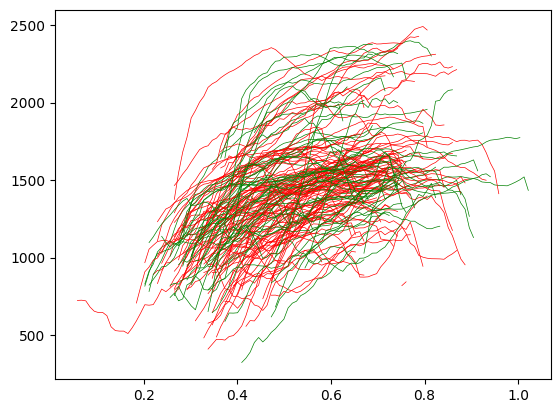

In [91]:
import numpy as np
import pandas as pd
import math
from scipy import signal

ids = []
offsets = []
peak_norms = []
slope1 = []
slope2 = []
dists = []
dist_to_emb = []
init_size1 = []
init_size2 = []
avg_degree = []
max_size = []
q1_size = []
q2_size = []
q1_solidity = []
q2_solidity = []

appear_pn1 = []
appear_pn2 = []
dt_appear = []
fade_pn1 = []
fade_pn2 = []
for id_ in merged_df['embryo_id'].drop_duplicates():
    # First PN: fill NaNs, compute time, extract active segment
    group1 = full_pn1_df[full_pn1_df['embryo_id'] == id_].copy()#group1.copy()
    group1['area'] = group1['area'].fillna(1)
    group1['time'] = group1['dt'].cumsum()
    start1, len1 = find_signal(group1['area'].values != 1)
    first_pn = group1.iloc[start1 : start1 + len1].reset_index(drop=True)

    # Second PN: same steps
    group2 = full_pn2_df[full_pn2_df['embryo_id'] == id_].copy()
    group2['area'] = group2['area'].fillna(1)
    group2['time'] = group2['dt'].cumsum()
    start2, len2 = find_signal(group2['area'].values != 1)
    second_pn = group2.iloc[start2 : start2 + len2].reset_index(drop=True)

    # whole_emb_slice = whole_emb_all_df.iloc[start1 : start1 + len1]

    appear_pn1.append(first_pn.iloc[0]['time'])
    appear_pn2.append(second_pn.iloc[0]['time'])

    dt_appear.append(second_pn.iloc[0]['time']-first_pn.iloc[0]['time'])

    fade_pn1.append(first_pn.iloc[-1]['time'])
    fade_pn2.append(second_pn.iloc[-1]['time'])

    init_size1.append(first_pn['area'].iloc[:5].mean()/second_pn['area'].iloc[:5].mean())

    dx = first_pn['x'].values  - group2['x'].iloc[start1 : start1 + len1].values
    dy = first_pn['y'].values  - group2['y'].iloc[start1 : start1 + len1].values
    angle_rad = np.atan2(dy, dx)       # result in radians, ∈ (−π,π]
    angle_deg = np.degrees(angle_rad[~np.isnan(angle_rad)])


    max_size.append(first_pn['area'].max())
    q1_size.append(first_pn['area'].quantile(0.1))
    q2_size.append(first_pn['area'].quantile(0.9))
    avg_degree.append(np.quantile(angle_deg,0.1))

    eccentricity_to_embryo = 0
    # np.sqrt(
    #     (first_pn['x'].values - whole_emb_slice['x'].values)**2 +
    #     (first_pn['y'].values - whole_emb_slice['y'].values)**2
    # )
    
    # dist_to_emb.append(eccentricity_to_embryo[~np.isnan(eccentricity_to_embryo)].mean())
    dist = np.sqrt(
        (group1['x'].values - group2['x'].values)**2 +
        (group1['y'].values - group2['y'].values)**2
    )
  
    dists.append(dist[~np.isnan(dist)].mean())

    # Offset difference
    offset_diff = (start2 + len2) - (start1 + len1)
    if offset_diff != 0:
        ids.append(id_)
        offsets.append(offset_diff)

    # Perimeter cross-correlation
    sig1 = first_pn['area']
    sig2 = second_pn['area']
    corr = signal.correlate(sig1, sig2)
    peak = corr.max()
    norm = np.linalg.norm(sig1) * np.linalg.norm(sig2)
    peak_norm = peak / norm if norm != 0 else 0
    peak_norms.append(peak_norm)

    # Area ratio (onl
    
    import statsmodels.api as sm
    mod = sm.OLS( first_pn['area'].values, first_pn['time'].values)
    res = mod.fit()
    
    slope1.append(res.params[0])


    mod = sm.OLS(second_pn['area'].values,second_pn['time'].values, )
    res = mod.fit()

    slope2.append(res.params[0])

    smmoothen_pn1 = first_pn[['time','area']].rolling(12).mean()
    
    embryo_lbl = merged_df.loc[merged_df['embryo_id']==id_]['y'].values[0]

    plt.plot( smmoothen_pn1['time'].values,smmoothen_pn1['area'].values,color='red' if embryo_lbl==0 else 'green', lw=-.5)

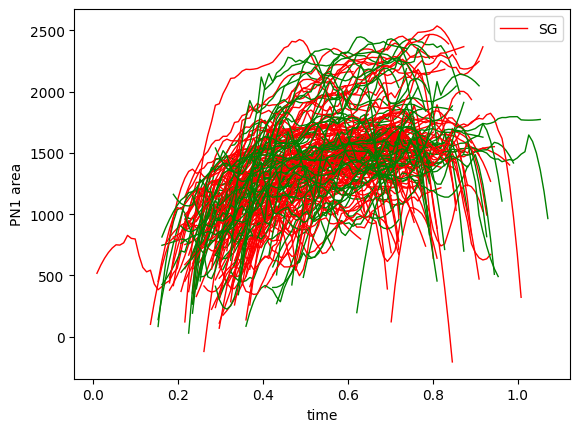

In [153]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import savgol_filter
import statsmodels.api as sm

# parameters for smoothing
SG_WINDOW = 11     # must be odd
SG_POLYORDER = 2
EMA_SPAN   = 12

# storage lists
ids = []
offsets = []
peak_norms = []
slope1 = []
slope2 = []
dists = []
appear_pn1 = []
appear_pn2 = []
dt_appear = []
fade_pn1 = []
fade_pn2 = []
init_size1 = []
init_size2 = []
avg_degree = []
max_size = []
q1_size = []
q2_size = []

for emb_id in merged_df['embryo_id'].drop_duplicates():
    # --- load & trim PN1 ---
    g1 = full_pn1_df[full_pn1_df['embryo_id'] == emb_id].copy()
    g1['area'] = g1['area'].fillna(1)
    g1['time'] = g1['dt'].cumsum()
    start1, length1 = find_signal(g1['area'].values != 1)
    first_pn = g1.iloc[start1:start1+length1].reset_index(drop=True)

    # --- load & trim PN2 ---
    g2 = full_pn2_df[full_pn2_df['embryo_id'] == emb_id].copy()
    g2['area'] = g2['area'].fillna(1)
    g2['time'] = g2['dt'].cumsum()
    start2, length2 = find_signal(g2['area'].values != 1)
    second_pn = g2.iloc[start2:start2+length2].reset_index(drop=True)

    # appearance / fade times
    appear_pn1.append(first_pn.at[0, 'time'])
    appear_pn2.append(second_pn.at[0, 'time'])
    dt_appear.append(appear_pn2[-1] - appear_pn1[-1])
    fade_pn1.append(first_pn.at[first_pn.index[-1], 'time'])
    fade_pn2.append(second_pn.at[second_pn.index[-1], 'time'])

    # initial size ratio
    init_size1.append(first_pn['area'].iloc[:5].mean() / second_pn['area'].iloc[:5].mean())

    # --- smoothing ---
    # Savitzky–Golay
    if len(first_pn['area']) >= SG_WINDOW:
        first_pn['area_sg'] = savgol_filter(first_pn['area'], SG_WINDOW, SG_POLYORDER)
    else:
        first_pn['area_sg'] = first_pn['area']
    if len(second_pn['area']) >= SG_WINDOW:
        second_pn['area_sg'] = savgol_filter(second_pn['area'], SG_WINDOW, SG_POLYORDER)
    else:
        second_pn['area_sg'] = second_pn['area']

    # Exponential moving average
    first_pn['area_ema']  = first_pn['area'].ewm(span=EMA_SPAN, adjust=False).mean()
    second_pn['area_ema'] = second_pn['area'].ewm(span=EMA_SPAN, adjust=False).mean()

    # --- distance between PNs ---
    dist = np.sqrt((g1['x'].values - g2['x'].values)**2 + (g1['y'].values - g2['y'].values)**2)
    dists.append(np.nanmean(dist))

    # --- offset diff ---
    od = (start2 + length2) - (start1 + length1)
    if od != 0:
        ids.append(emb_id)
        offsets.append(od)

    # --- cross-correlation on SG-smoothed series ---
    sig1 = first_pn['area_sg'].values
    sig2 = second_pn['area_sg'].values
    corr = signal.correlate(sig1, sig2, mode='full')
    peak = np.max(corr)
    norm = np.linalg.norm(sig1) * np.linalg.norm(sig2)
    peak_norms.append(peak / norm if norm != 0 else 0)

    # --- growth slopes via OLS on SG-smoothed ---
    X1 = first_pn['time'].values[:, None]
    mod1 = sm.OLS(first_pn['area_sg'].values, X1)
    res1 = mod1.fit()
    slope1.append(res1.params[0])

    X2 = second_pn['time'].values[:, None]
    mod2 = sm.OLS(second_pn['area_sg'].values, X2)
    res2 = mod2.fit()
    slope2.append(res2.params[0])

    # --- size stats ---
    max_size.append(first_pn['area_sg'].max())
    q1_size.append(first_pn['area_sg'].quantile(0.1))
    q2_size.append(first_pn['area_sg'].quantile(0.9))

    # --- orientation ---
    dx = first_pn['x'].values - second_pn['x'].reindex(first_pn.index, method='nearest').values
    dy = first_pn['y'].values - second_pn['y'].reindex(first_pn.index, method='nearest').values
    angles = np.degrees(np.arctan2(dy, dx))
    avg_degree.append(np.nanquantile(angles, 0.1))

    # --- plot raw vs denoised PN1 ---
    lbl = merged_df.loc[merged_df['embryo_id']==emb_id, 'y'].iloc[0]
    color = 'red' if lbl==0 else 'green'
    # plt.plot(first_pn['time'], first_pn['area'],   alpha=0.3, color=color, label='raw' if emb_id==merged_df['embryo_id'].iloc[0] else "")
    plt.plot(first_pn['time'], first_pn['area_sg'], lw=1, color=color, label='SG' if emb_id==merged_df['embryo_id'].iloc[0] else "")
    # plt.plot(first_pn['time'], first_pn['area_ema'], lw=1, ls='--', color=color, label='EMA' if emb_id==merged_df['embryo_id'].iloc[0] else "")

# finalize plot
plt.xlabel('time')
plt.ylabel('PN1 area')
plt.legend()
plt.show()


time_to_peak_pn1: p-value=0.8360
peak_amp_pn1: p-value=0.2125
auc_pn1: p-value=0.1229
auc_pn2: p-value=0.2438
slope_initial_pn1: p-value=0.9898
slope_initial_pn2: p-value=0.9048


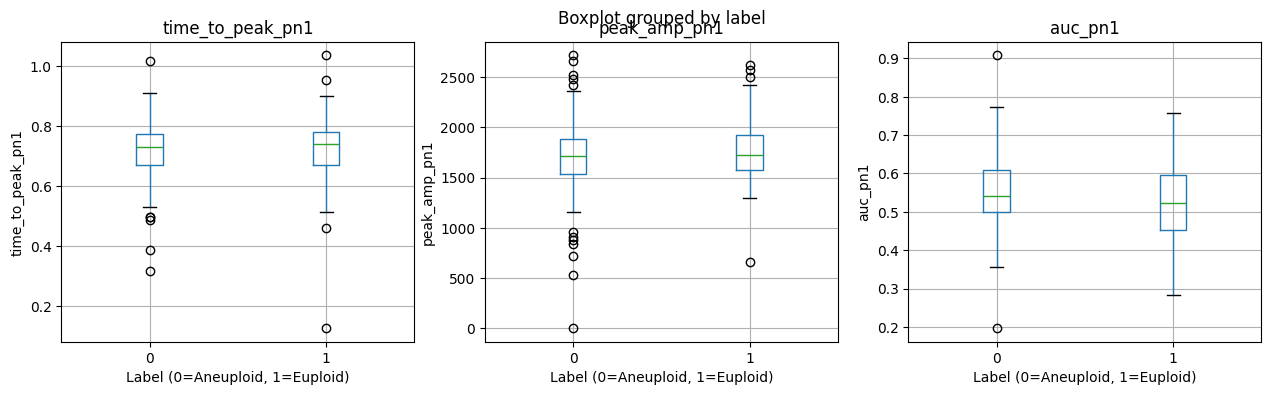

In [183]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.stats import ttest_ind

SG_WINDOW = 11
SG_POLYORDER = 2

features = []

for emb_id in merged_df['embryo_id'].unique():
    pn1_df = full_pn1_df[full_pn1_df['embryo_id'] == emb_id].copy().reset_index()
    pn2_df = full_pn2_df[full_pn2_df['embryo_id'] == emb_id].copy().reset_index()

    pn1_df['area'] = pn1_df['area'].fillna(1)
    pn2_df['area'] = pn2_df['area'].fillna(1)

    pn1_df['time'] = pn1_df['dt'].cumsum()
    pn2_df['time'] = pn2_df['dt'].cumsum()

    # Smoothing
    if len(pn1_df['area']) >= SG_WINDOW:
        pn1_df['area_sg'] = savgol_filter(pn1_df['area'], SG_WINDOW, SG_POLYORDER)
    else:
        pn1_df['area_sg'] = pn1_df['area']

    if len(pn2_df['area']) >= SG_WINDOW:
        pn2_df['area_sg'] = savgol_filter(pn2_df['area'], SG_WINDOW, SG_POLYORDER)
    else:
        pn2_df['area_sg'] = pn2_df['area']

    # Normalize areas
    pn1_df['area_norm'] = (pn1_df['area_sg'] - pn1_df['area_sg'].min()) / (pn1_df['area_sg'].max() - pn1_df['area_sg'].min())
    pn2_df['area_norm'] = (pn2_df['area_sg'] - pn2_df['area_sg'].min()) / (pn2_df['area_sg'].max() - pn2_df['area_sg'].min())

    # Peak time
    time_to_peak_pn1 = pn1_df['time'].iloc[pn1_df['area_sg'].idxmax()]
    time_to_peak_pn2 = pn2_df['time'].iloc[pn2_df['area_sg'].idxmax()]

    # Peak amplitude
    peak_amp_pn1 = pn1_df['area_sg'].max() - pn1_df['area_sg'].iloc[0]
    peak_amp_pn2 = pn2_df['area_sg'].max() - pn2_df['area_sg'].iloc[0]

    # Area Under Curve (AUC)
    # With these two lines:
    auc_pn1 = np.trapezoid(pn1_df['area_norm'], pn1_df['time'])
    auc_pn2 = np.trapezoid(pn2_df['area_norm'], pn2_df['time'])

    label = merged_df.loc[merged_df['embryo_id'] == emb_id, 'y'].iloc[0]

    features.append({
        'embryo_id': emb_id,
        'time_to_peak_pn1': time_to_peak_pn1,
        'time_to_peak_pn2': time_to_peak_pn2,
        'peak_amp_pn1': peak_amp_pn1,
        'peak_amp_pn2': peak_amp_pn2,
        'auc_pn1': auc_pn1,
        'auc_pn2': auc_pn2,
        'label': int(label>1)
    })
    # Time differences between PN1 and PN2 peaks
    delta_time_peak = abs(time_to_peak_pn1 - time_to_peak_pn2)

    # Ratio of peak amplitudes
    peak_amp_ratio = peak_amp_pn1 / peak_amp_pn2 if peak_amp_pn2 != 0 else np.nan

    # Difference in AUC
    auc_diff = auc_pn1 - auc_pn2

    # Duration of pronuclei visibility
    duration_pn1 = pn1_df['time'].iloc[-1] - pn1_df['time'].iloc[0]
    duration_pn2 = pn2_df['time'].iloc[-1] - pn2_df['time'].iloc[0]

    # Initial growth slope (first 5 points)
    initial_points = 5
    if len(pn1_df) >= initial_points:
        slope_initial_pn1 = np.polyfit(pn1_df['time'][:initial_points], pn1_df['area_sg'][:initial_points], 1)[0]
    else:
        slope_initial_pn1 = np.nan

    if len(pn2_df) >= initial_points:
        slope_initial_pn2 = np.polyfit(pn2_df['time'][:initial_points], pn2_df['area_sg'][:initial_points], 1)[0]
    else:
        slope_initial_pn2 = np.nan

    # Append to features list
    features[-1].update({
        'delta_time_peak': delta_time_peak,
        'peak_amp_ratio': peak_amp_ratio,
        'auc_diff': auc_diff,
        'duration_pn1': duration_pn1,
        'duration_pn2': duration_pn2,
        'slope_initial_pn1': slope_initial_pn1,
        'slope_initial_pn2': slope_initial_pn2
    })

features_df = pd.DataFrame(features)

# Quick visualization example
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for feature, ax in zip(['time_to_peak_pn1', 'peak_amp_pn1', 'auc_pn1','slope_initial_pn2'], axes):
    features_df.boxplot(column=feature, by='label', ax=ax)
    ax.set_title(feature)
    ax.set_xlabel('Label (0=Aneuploid, 1=Euploid)')
    ax.set_ylabel(feature)

# plt.tight_layout()
# plt.show()

# Example statistical check
for feat in ['time_to_peak_pn1', 'peak_amp_pn1', 'auc_pn1','auc_pn2','slope_initial_pn1','slope_initial_pn2']:
    group1 = features_df[features_df['label'] == 1][feat]
    group0 = features_df[features_df['label'] == 0][feat]
    stat, pval = ttest_ind(group1, group0, nan_policy='omit')
    print(f'{feat}: p-value={pval:.4f}')


In [173]:
time_to_peak_pn1

np.float64(0.7290000000000004)

In [165]:
pn1_df['time'].shape#.iloc[pn1_df['area_sg'].idxmax()]

(200,)

Text(0.5, 0, 'Time')

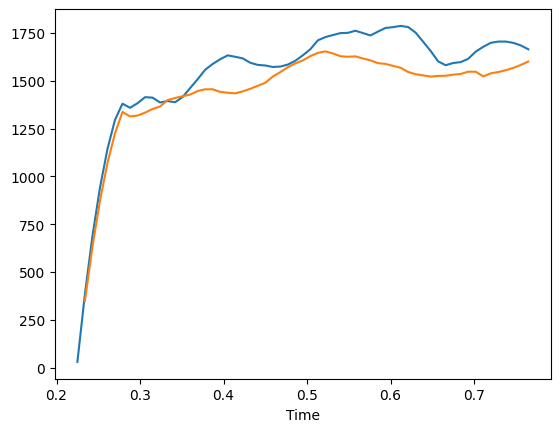

In [157]:
# pronuclei size
plt.plot(first_pn[['time']], first_pn[['area_sg']])
plt.plot(second_pn[['time']], second_pn[['area_sg']])
plt.xlabel('Time')

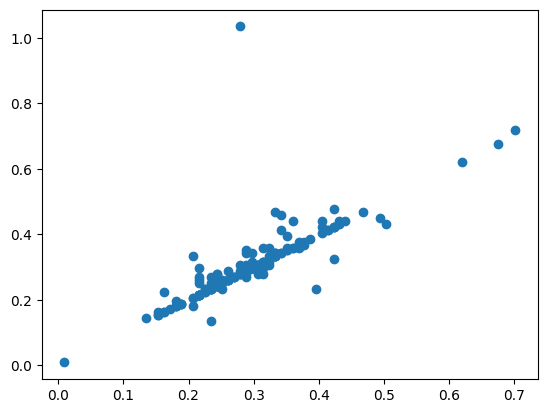

In [97]:
plt.scatter(appear_pn1,appear_pn2)

In [98]:
time_features = [
    'Age',
    'tPNf',
    't2',
    't3',
    't4',
    't5',
    't6',
    't7',
    't8',
]

In [248]:
import pandas as pd
import numpy as np
from scipy import signal
import statsmodels.api as sm


# Assuming find_signal is defined as in your example
def find_signal(arr: np.ndarray[bool]):
    # Find the largest continuous block of ones
    max_len = 0
    max_start = 0
    curr_len = 0
    curr_start = 0
    for i in range(len(arr)):
        if arr[i] == 1:
            if curr_len == 0:
                curr_start = i
            curr_len += 1
        else:
            if curr_len > max_len:
                max_len = curr_len
                max_start = curr_start
            curr_len = 0
    # Check at the end in case the longest sequence is at the end
    if curr_len > max_len:
        max_len = curr_len
        max_start = curr_start
    return max_start, max_len


def calculate_pn_metrics_for_embryo(pn1_df_orig, pn2_df_orig,
                                    whole_embryo_df_orig, embryo_id):
    features = {'embryo_id': embryo_id}

    pn1_df = pn1_df_orig.copy()
    pn2_df = pn2_df_orig.copy()
    whole_embryo_df = whole_embryo_df_orig.copy()

    # --- Preprocessing and Signal Identification ---
    required_cols_pn = ['area', 'dt', 'centroid_col', 'centroid_row']

    for df_name, df in [('pn1', pn1_df), ('pn2', pn2_df)]:
        if not all(col in df.columns for col in required_cols_pn):
            features.update(
                {'error': f'Missing cols in {df_name} for embryo {embryo_id}'})
            return features

        df['area_filled'] = df['area'].fillna(0)
        # Ensure 'dt' is numeric before cumsum
        if not pd.api.types.is_numeric_dtype(df['dt']):
            features.update({
                'error':
                f"'dt' column in {df_name} is not numeric for embryo {embryo_id}"
            })
            return features
        df['time'] = df['dt'].cumsum()

    pn1_visible_mask = pn1_df['area_filled'] > 1
    start1, len1 = find_signal(pn1_visible_mask.values)
    pn1_active = pn1_df.iloc[start1:start1 + len1].reset_index(drop=True)

    pn2_visible_mask = pn2_df['area_filled'] > 1
    start2, len2 = find_signal(pn2_visible_mask.values)
    pn2_active = pn2_df.iloc[start2:start2 + len2].reset_index(drop=True)

    if pn1_active.empty or pn2_active.empty:
        features.update({
            'error':
            f'PN1 or PN2 not sufficiently visible for embryo {embryo_id}'
        })
        return features

    # --- I. Basic Temporal Metrics ---
    features['pn1_appearance_time'] = pn1_active['time'].iloc[0]
    features['pn2_appearance_time'] = pn2_active['time'].iloc[0]
    features['pn1_fade_time'] = pn1_active['time'].iloc[-1]
    features['pn2_fade_time'] = pn2_active['time'].iloc[-1]

    features['pn1_duration'] = features['pn1_fade_time'] - features[
        'pn1_appearance_time']
    features['pn2_duration'] = features['pn2_fade_time'] - features[
        'pn2_appearance_time']

    features['dt_appearance'] = features['pn2_appearance_time'] - features[
        'pn1_appearance_time']
    features['dt_fade'] = features['pn2_fade_time'] - features['pn1_fade_time']
    features['offset_frames_activity_diff'] = (start2 + len2) - (start1 + len1)

    # --- II. Size and Growth Metrics ---
    k_initial = min(5, len(pn1_active), len(pn2_active))
    if k_initial > 0:
        pn1_initial_area_mean = pn1_active['area'].iloc[:k_initial].mean()
        pn2_initial_area_mean = pn2_active['area'].iloc[:k_initial].mean()
        features[
            'initial_size_ratio_pn1_pn2'] = pn1_initial_area_mean / pn2_initial_area_mean if pn2_initial_area_mean != 0 else np.nan
    else:
        features['initial_size_ratio_pn1_pn2'] = np.nan

    for prefix, df_active in [('pn1', pn1_active), ('pn2', pn2_active)]:
        if df_active.empty:  # Should not happen if we passed the earlier check, but good for safety
            for key_suffix in [
                    'area_max', 'area_q10', 'area_q90', 'area_mean',
                    'area_median', 'area_std', 'growth_slope',
                    'growth_intercept', 'time_to_max_area'
            ]:
                features[f'{prefix}_{key_suffix}'] = np.nan
            continue

        features[f'{prefix}_area_max'] = df_active['area'].max()
        features[f'{prefix}_area_q10'] = df_active['area'].quantile(0.1)
        features[f'{prefix}_area_q90'] = df_active['area'].quantile(0.9)
        features[f'{prefix}_area_mean'] = df_active['area'].mean()
        features[f'{prefix}_area_median'] = df_active['area'].median()
        features[f'{prefix}_area_std'] = df_active['area'].std()

        df_active['time_rel'] = df_active['time'] - df_active['time'].iloc[0]
        if len(df_active) > 1:  # Need at least 2 points for OLS
            try:
                # Ensure 'area' is numeric for OLS
                area_values = pd.to_numeric(df_active['area'],
                                            errors='coerce').dropna()
                time_rel_values = pd.to_numeric(
                    df_active.loc[area_values.index, 'time_rel'],
                    errors='coerce').dropna()

                # Align them again after potential drops
                common_idx = area_values.index.intersection(
                    time_rel_values.index)
                area_values = area_values.loc[common_idx]
                time_rel_values = time_rel_values.loc[common_idx]

                if len(area_values) > 1:
                    mod = sm.OLS(area_values.values,
                                 sm.add_constant(time_rel_values.values))
                    res = mod.fit()
                    features[f'{prefix}_growth_slope'] = res.params[1]
                    features[f'{prefix}_growth_intercept'] = res.params[0]
                else:
                    features[f'{prefix}_growth_slope'], features[
                        f'{prefix}_growth_intercept'] = np.nan, np.nan
            except Exception:  # Catch any other OLS errors
                features[f'{prefix}_growth_slope'], features[
                    f'{prefix}_growth_intercept'] = np.nan, np.nan
        else:
            features[f'{prefix}_growth_slope'], features[
                f'{prefix}_growth_intercept'] = np.nan, np.nan

        if not df_active[
                'area'].empty:  # Check if area series is not empty before idxmax
            features[f'{prefix}_time_to_max_area'] = df_active.loc[
                df_active['area'].idxmax(), 'time_rel']
        else:
            features[f'{prefix}_time_to_max_area'] = np.nan

    features['area_ratio_mean_pn1_pn2'] = (
        features.get('pn1_area_mean', np.nan) /
        features.get('pn2_area_mean', np.nan) if features.get('pn2_area_mean')
        and features.get('pn2_area_mean') != 0 else np.nan)
    features['area_ratio_max_pn1_pn2'] = (
        features.get('pn1_area_max', np.nan) /
        features.get('pn2_area_max', np.nan) if features.get('pn2_area_max')
        and features.get('pn2_area_max') != 0 else np.nan)

    # --- III. Shape Metrics (Average over visible period) ---
    shape_cols = [
        'solidity', 'eccentricity', 'circularity_std', 'aspect_ratio',
        'extent', 'equivalent_diameter'
    ]

    for prefix, df_active in [('pn1', pn1_active), ('pn2', pn2_active)]:
        if df_active.empty:
            for col in shape_cols:
                features[f'{prefix}_{col}_mean'], features[
                    f'{prefix}_{col}_std'], features[
                        f'{prefix}_{col}_median'] = np.nan, np.nan, np.nan
            for i in range(7):
                features[f'{prefix}_hu{i+1}_mean'] = np.nan
            continue

        else:
            pass
        if 'circularity_std' not in df_active.columns and 'area' in df_active.columns and 'perimeter' in df_active.columns:
            df_active.loc[:, 'circularity_std'] = (
                4 * np.pi * df_active['area']) / (df_active['perimeter']**2)
            df_active.loc[df_active['perimeter'] == 0, 'circularity_std'] = 0.0

        for col in shape_cols:
            if col in df_active.columns:
                features[f'{prefix}_{col}_mean'] = df_active[col].mean()
                features[f'{prefix}_{col}_std'] = df_active[col].std()
                features[f'{prefix}_{col}_median'] = df_active[col].median()
            else:
                features[f'{prefix}_{col}_mean'], features[
                    f'{prefix}_{col}_std'], features[
                        f'{prefix}_{col}_median'] = np.nan, np.nan, np.nan

        if 'hu_moments' in df_active.columns:
            hu_array = np.array(df_active['hu_moments'].dropna().tolist())
            if hu_array.ndim == 2 and hu_array.shape[0] > 0 and hu_array.shape[
                    1] == 7:
                mean_hu = np.nanmean(hu_array, axis=0)
                for i in range(7):
                    features[f'{prefix}_hu{i+1}_mean'] = mean_hu[i]
            else:
                for i in range(7):
                    features[f'{prefix}_hu{i+1}_mean'] = np.nan
        else:
            for i in range(7):
                features[f'{prefix}_hu{i+1}_mean'] = np.nan

    # --- IV. Relational Metrics (Distance, Angle, Contact) ---
    # Assuming 'time' column is float (e.g., hours)
    # Set a small numeric tolerance, e.g., a fraction of your typical 'dt'
    # If average 'dt' is say 0.2 hours, tolerance could be 0.01 or 0.001
    time_tolerance = 0.01  # ADJUST THIS BASED ON YOUR TIME UNITS AND PRECISION

    pn_common_merged = pd.merge_asof(pn1_active.sort_values('time'),
                                     pn2_active.sort_values('time'),
                                     on='time',
                                     direction='nearest',
                                     suffixes=('_pn1', '_pn2'),
                                     tolerance=time_tolerance)

    common_time_start_actual = max(
        features.get('pn1_appearance_time', -np.inf),
        features.get('pn2_appearance_time', -np.inf))
    common_time_end_actual = min(features.get('pn1_fade_time', np.inf),
                                 features.get('pn2_fade_time', np.inf))

    # Ensure start is not after end
    if common_time_start_actual > common_time_end_actual:
        pn_common_merged = pd.DataFrame()  # No valid common period
    else:
        pn_common_merged = pn_common_merged[
            (pn_common_merged['time'] >= common_time_start_actual)
            & (pn_common_merged['time'] <= common_time_end_actual)].dropna(
                subset=[
                    'centroid_col_pn1', 'centroid_row_pn1', 'centroid_col_pn2',
                    'centroid_row_pn2'
                ])

    if not pn_common_merged.empty and len(
            pn_common_merged) > 0:  # Changed to > 0 for single point case
        dx = pn_common_merged['centroid_col_pn1'].values - pn_common_merged[
            'centroid_col_pn2'].values
        dy = pn_common_merged['centroid_row_pn1'].values - pn_common_merged[
            'centroid_row_pn2'].values
        inter_pn_dist = np.sqrt(dx**2 + dy**2)

        features['inter_pn_dist_mean'] = np.nanmean(
            inter_pn_dist) if inter_pn_dist.size > 0 else np.nan
        features['inter_pn_dist_min'] = np.nanmin(
            inter_pn_dist) if inter_pn_dist.size > 0 else np.nan
        features['inter_pn_dist_max'] = np.nanmax(
            inter_pn_dist) if inter_pn_dist.size > 0 else np.nan
        features['inter_pn_dist_std'] = np.nanstd(
            inter_pn_dist
        ) if inter_pn_dist.size > 1 else 0.0  # std requires >1 point

        if inter_pn_dist.size > 0:
            angle_rad = np.arctan2(dy, dx)
            # angle_deg = np.degrees(angle_rad) # Not used directly
            features['inter_pn_angle_mean_deg_circ'] = np.degrees(
                np.arctan2(np.nanmean(np.sin(angle_rad)),
                           np.nanmean(np.cos(angle_rad))))
            R_angle = np.sqrt(
                np.nanmean(np.sin(angle_rad))**2 +
                np.nanmean(np.cos(angle_rad))**2)
            features[
                'inter_pn_angle_circular_variance'] = 1 - R_angle if R_angle <= 1 and R_angle >= 0 else (
                    0.0 if R_angle > 1 else np.nan)  # Clamp R
            features['inter_pn_angle_dispersion_deg'] = np.degrees(
                np.sqrt(-2 * np.log(R_angle))
            ) if R_angle > 0 and R_angle <= 1 else np.nan
        else:
            for k_ in [
                    'inter_pn_angle_mean_deg_circ',
                    'inter_pn_angle_circular_variance',
                    'inter_pn_angle_dispersion_deg'
            ]:
                features[k_] = np.nan

        if 'equivalent_diameter_pn1' in pn_common_merged.columns and \
           'equivalent_diameter_pn2' in pn_common_merged.columns and \
           inter_pn_dist.size > 0: # Check if inter_pn_dist was calculated
            sum_radii = (pn_common_merged['equivalent_diameter_pn1'].values / 2.0) + \
                        (pn_common_merged['equivalent_diameter_pn2'].values / 2.0)

            contact_metric = inter_pn_dist < sum_radii
            features['pn_contact_time_ratio'] = np.nanmean(
                contact_metric) if contact_metric.size > 0 else 0.0

            overlap_depth = sum_radii - inter_pn_dist
            features['pn_overlap_depth_mean_on_contact'] = np.nanmean(
                overlap_depth[contact_metric]) if np.any(
                    contact_metric) else 0.0
        else:
            features['pn_contact_time_ratio'] = np.nan
            features['pn_overlap_depth_mean_on_contact'] = np.nan
    else:  # pn_common_merged is empty or only one row
        for k_ in [
                'inter_pn_dist_mean', 'inter_pn_dist_min', 'inter_pn_dist_max',
                'inter_pn_dist_std', 'inter_pn_angle_mean_deg_circ',
                'inter_pn_angle_circular_variance',
                'inter_pn_angle_dispersion_deg', 'pn_contact_time_ratio',
                'pn_overlap_depth_mean_on_contact'
        ]:
            features[k_] = np.nan

    # Distance of PN centroids to overall embryo centroid
    # Ensure whole_embryo_df has 'time' and coordinate columns
    if 'time' in whole_embryo_df.columns and \
       'centroid_col' in whole_embryo_df.columns and \
       'centroid_row' in whole_embryo_df.columns:

        whole_emb_df_renamed = whole_embryo_df.rename(
            columns={
                'centroid_col': 'emb_centroid_col',
                'centroid_row': 'emb_centroid_row'
            })
        for prefix, df_active in [('pn1', pn1_active), ('pn2', pn2_active)]:
            if df_active.empty:
                features[f'{prefix}_dist_to_embryo_center_mean'], features[
                    f'{prefix}_dist_to_embryo_center_std'] = np.nan, np.nan
                continue

            merged_pn_emb = pd.merge_asof(
                df_active.sort_values('time'),
                whole_emb_df_renamed.sort_values('time'),
                on='time',
                direction='nearest',
                tolerance=time_tolerance  # Use the same numeric tolerance
            )
            if not merged_pn_emb.empty and 'emb_centroid_col' in merged_pn_emb.columns and \
               'centroid_col' in merged_pn_emb.columns: # centroid_col is from df_active

                dist_to_emb_center = np.sqrt(
                    (merged_pn_emb['centroid_col'].values -
                     merged_pn_emb['emb_centroid_col'].values)**2 +
                    (merged_pn_emb['centroid_row'].values -
                     merged_pn_emb['emb_centroid_row'].values)**2)
                features[f'{prefix}_dist_to_embryo_center_mean'] = np.nanmean(
                    dist_to_emb_center
                ) if dist_to_emb_center.size > 0 else np.nan
                features[f'{prefix}_dist_to_embryo_center_std'] = np.nanstd(
                    dist_to_emb_center) if dist_to_emb_center.size > 1 else 0.0
            else:
                features[f'{prefix}_dist_to_embryo_center_mean'], features[
                    f'{prefix}_dist_to_embryo_center_std'] = np.nan, np.nan
    else:
        for prefix in ['pn1', 'pn2']:
            features[f'{prefix}_dist_to_embryo_center_mean'], features[
                f'{prefix}_dist_to_embryo_center_std'] = np.nan, np.nan

    # --- V. Movement and Trajectory Metrics ---
    def calculate_trajectory_metrics_refined(
            pn_track_df, df_prefix_key):  # Renamed to avoid conflict
        traj_feats = {
            f'{df_prefix_key}_traj_speed_mean': np.nan,
            f'{df_prefix_key}_traj_speed_std': np.nan,
            f'{df_prefix_key}_traj_total_displacement': np.nan,
            f'{df_prefix_key}_traj_path_length': np.nan,
            f'{df_prefix_key}_traj_straightness': np.nan,
            f'{df_prefix_key}_traj_msd_slope_proxy': np.nan
        }
        if pn_track_df.empty or len(pn_track_df) < 2:
            return traj_feats

        # Ensure 'centroid_col' and 'centroid_row' are numeric
        pn_track_df.loc[:, 'centroid_col'] = pd.to_numeric(
            pn_track_df['centroid_col'], errors='coerce')
        pn_track_df.loc[:, 'centroid_row'] = pd.to_numeric(
            pn_track_df['centroid_row'], errors='coerce')
        pn_track_df_cleaned = pn_track_df.dropna(
            subset=['centroid_col', 'centroid_row', 'time'])

        if len(pn_track_df_cleaned) < 2:
            return traj_feats

        dx = np.diff(pn_track_df_cleaned['centroid_col'].values)
        dy = np.diff(pn_track_df_cleaned['centroid_row'].values)
        dt_steps = np.diff(pn_track_df_cleaned['time'].values)

        # Filter out zero or negative dt_steps to avoid issues
        valid_dt_mask = dt_steps > 0
        if not np.any(valid_dt_mask):  # No valid time steps
            return traj_feats

        dx = dx[valid_dt_mask]
        dy = dy[valid_dt_mask]
        dt_steps = dt_steps[valid_dt_mask]

        if dt_steps.size == 0:  # Still no valid steps after filtering
            return traj_feats

        dist_steps = np.sqrt(dx**2 + dy**2)
        speeds = dist_steps / dt_steps

        traj_feats[f'{df_prefix_key}_traj_path_length'] = np.sum(dist_steps)

        traj_feats[f'{df_prefix_key}_traj_total_displacement'] = np.sqrt(
            (pn_track_df_cleaned['centroid_col'].iloc[-1] -
             pn_track_df_cleaned['centroid_col'].iloc[0])**2 +
            (pn_track_df_cleaned['centroid_row'].iloc[-1] -
             pn_track_df_cleaned['centroid_row'].iloc[0])**2)

        path_len = traj_feats[f'{df_prefix_key}_traj_path_length']
        total_disp = traj_feats[f'{df_prefix_key}_traj_total_displacement']
        traj_feats[
            f'{df_prefix_key}_traj_straightness'] = total_disp / path_len if path_len > 0 else (
                1.0 if total_disp == 0 and path_len == 0 else np.nan)

        time_elapsed_total = pn_track_df_cleaned['time'].iloc[
            -1] - pn_track_df_cleaned['time'].iloc[0]
        traj_feats[
            f'{df_prefix_key}_traj_msd_slope_proxy'] = total_disp**2 / time_elapsed_total if time_elapsed_total > 0 else np.nan

        traj_feats[f'{df_prefix_key}_traj_speed_mean'] = np.nanmean(
            speeds) if speeds.size > 0 else np.nan
        traj_feats[f'{df_prefix_key}_traj_speed_std'] = np.nanstd(
            speeds) if speeds.size > 1 else 0.0  # std requires >1 point

        return traj_feats

    features.update(calculate_trajectory_metrics_refined(pn1_active, 'pn1'))
    features.update(calculate_trajectory_metrics_refined(pn2_active, 'pn2'))

    # Relative movement: Speed of approach/separation
    # Use pn_common_merged here for aligned data
    if not pn_common_merged.empty and len(pn_common_merged) > 1:
        # Recalculate inter_pn_dist from the final pn_common_merged
        dx_c = pn_common_merged['centroid_col_pn1'].values - pn_common_merged[
            'centroid_col_pn2'].values
        dy_c = pn_common_merged['centroid_row_pn1'].values - pn_common_merged[
            'centroid_row_pn2'].values
        inter_pn_dist_common = np.sqrt(dx_c**2 + dy_c**2)

        if len(inter_pn_dist_common) > 1:
            d_dist = np.diff(inter_pn_dist_common)
            dt_steps_common = np.diff(pn_common_merged['time'].values)

            valid_dt_mask_common = dt_steps_common > 0
            if not np.any(valid_dt_mask_common):
                features['inter_pn_approach_speed_mean'], features[
                    'inter_pn_approach_speed_max'], features[
                        'inter_pn_approach_speed_min'] = np.nan, np.nan, np.nan
            else:
                d_dist = d_dist[valid_dt_mask_common]
                dt_steps_common = dt_steps_common[valid_dt_mask_common]

                if dt_steps_common.size == 0:
                    features['inter_pn_approach_speed_mean'], features[
                        'inter_pn_approach_speed_max'], features[
                            'inter_pn_approach_speed_min'] = np.nan, np.nan, np.nan
                else:
                    approach_speeds = -d_dist / dt_steps_common
                    features['inter_pn_approach_speed_mean'] = np.nanmean(
                        approach_speeds
                    ) if approach_speeds.size > 0 else np.nan
                    features['inter_pn_approach_speed_max'] = np.nanmax(
                        approach_speeds
                    ) if approach_speeds.size > 0 else np.nan
                    features['inter_pn_approach_speed_min'] = np.nanmin(
                        approach_speeds
                    ) if approach_speeds.size > 0 else np.nan
        else:  # len(inter_pn_dist_common) <= 1
            features['inter_pn_approach_speed_mean'], features[
                'inter_pn_approach_speed_max'], features[
                    'inter_pn_approach_speed_min'] = np.nan, np.nan, np.nan
    else:  # pn_common_merged empty or only one row
        features['inter_pn_approach_speed_mean'], features[
            'inter_pn_approach_speed_max'], features[
                'inter_pn_approach_speed_min'] = np.nan, np.nan, np.nan

    # --- VI. Fluctuation and Stability Metrics ---
    for prefix, df_active in [('pn1', pn1_active), ('pn2', pn2_active)]:
        if df_active.empty:
            features[f'{prefix}_area_cv'], features[
                f'{prefix}_area_smooth_num_turns'], features[
                    f'{prefix}_area_residual_std'] = np.nan, np.nan, np.nan
            continue

        mean_area = df_active['area'].mean()
        features[f'{prefix}_area_cv'] = df_active['area'].std(
        ) / mean_area if mean_area != 0 else np.nan

        # Ensure 'area' is numeric and has enough points for SavGol
        area_numeric = pd.to_numeric(df_active['area'],
                                     errors='coerce').dropna()
        if len(area_numeric) > 5:
            try:
                wl = min(11, len(area_numeric))
                if wl % 2 == 0: wl -= 1
                if wl >= 3:
                    polyorder = min(2, wl - 1)
                    area_smooth = signal.savgol_filter(area_numeric,
                                                       window_length=wl,
                                                       polyorder=polyorder)
                    if len(area_smooth) > 2:
                        deriv_smooth_sign_diff = np.diff(
                            np.sign(np.diff(area_smooth)))
                        features[f'{prefix}_area_smooth_num_turns'] = np.sum(
                            deriv_smooth_sign_diff != 0)
                    else:
                        features[f'{prefix}_area_smooth_num_turns'] = 0 if len(
                            area_smooth
                        ) > 1 else np.nan  # Or just np.nan if <3 points
                    features[f'{prefix}_area_residual_std'] = np.std(
                        area_numeric.values - area_smooth
                    )  # Ensure alignment if area_numeric was subsetted by dropna
                else:
                    features[f'{prefix}_area_smooth_num_turns'], features[
                        f'{prefix}_area_residual_std'] = np.nan, np.nan
            except Exception:  # Catch SavGol specific errors
                features[f'{prefix}_area_smooth_num_turns'], features[
                    f'{prefix}_area_residual_std'] = np.nan, np.nan
        else:
            features[f'{prefix}_area_smooth_num_turns'], features[
                f'{prefix}_area_residual_std'] = np.nan, np.nan

    # --- VII. Synchrony and Asymmetry Metrics ---
    # Using .get with default np.nan for robustness if a feature wasn't calculated
    features['asymmetry_duration'] = features.get(
        'pn1_duration', np.nan) - features.get('pn2_duration', np.nan)
    features['asymmetry_max_area'] = features.get(
        'pn1_area_max', np.nan) - features.get('pn2_area_max', np.nan)
    features['asymmetry_mean_area'] = features.get(
        'pn1_area_mean', np.nan) - features.get('pn2_area_mean', np.nan)
    features['asymmetry_time_to_max_area'] = features.get(
        'pn1_time_to_max_area', np.nan) - features.get('pn2_time_to_max_area',
                                                       np.nan)
    features['asymmetry_growth_slope'] = features.get(
        'pn1_growth_slope', np.nan) - features.get('pn2_growth_slope', np.nan)
    features['asymmetry_traj_speed_mean'] = features.get(
        'pn1_traj_speed_mean', np.nan) - features.get('pn2_traj_speed_mean',
                                                      np.nan)
    features['asymmetry_traj_straightness'] = features.get(
        'pn1_traj_straightness', np.nan) - features.get(
            'pn2_traj_straightness', np.nan)

    # Area Cross-Correlation
    if not pn_common_merged.empty and \
       'area_pn1' in pn_common_merged.columns and \
       'area_pn2' in pn_common_merged.columns:

        sig1 = pn_common_merged['area_pn1'].dropna(
        ).values  # Drop NaNs from area before processing
        sig2 = pn_common_merged['area_pn2'].dropna().values

        # Align signals if NaNs were dropped asymmetrically - take intersection of indices
        if 'area_pn1' in pn_common_merged and 'area_pn2' in pn_common_merged:
            common_idx_corr = pn_common_merged['area_pn1'].dropna(
            ).index.intersection(pn_common_merged['area_pn2'].dropna().index)
            sig1 = pn_common_merged.loc[common_idx_corr, 'area_pn1'].values
            sig2 = pn_common_merged.loc[common_idx_corr, 'area_pn2'].values

        if len(sig1) > 1 and len(sig1) == len(sig2):
            sig1_norm = (sig1 - np.mean(sig1)) / (np.std(sig1)
                                                  if np.std(sig1) > 0 else 1)
            sig2_norm = (sig2 - np.mean(sig2)) / (np.std(sig2)
                                                  if np.std(sig2) > 0 else 1)
            try:
                corr = signal.correlate(sig1_norm, sig2_norm, mode='same')
                if corr.size > 0:
                    peak_corr_idx = np.argmax(np.abs(corr))
                    features['pn_area_cross_corr_peak'] = corr[peak_corr_idx]
                    lags = signal.correlation_lags(
                        len(sig1_norm), len(sig2_norm),
                        mode="same")  # Ensure correct length
                    features['pn_area_cross_corr_lag'] = lags[peak_corr_idx]
                else:
                    features['pn_area_cross_corr_peak'], features[
                        'pn_area_cross_corr_lag'] = np.nan, np.nan
            except Exception:  # Catch any correlation errors
                features['pn_area_cross_corr_peak'], features[
                    'pn_area_cross_corr_lag'] = np.nan, np.nan
        else:
            features['pn_area_cross_corr_peak'], features[
                'pn_area_cross_corr_lag'] = np.nan, np.nan
    else:
        features['pn_area_cross_corr_peak'], features[
            'pn_area_cross_corr_lag'] = np.nan, np.nan

    return features


# --- Main Processing Script ---
# Assume full_pn1_df, full_pn2_df, whole_emb_all_df are loaded pandas DataFrames
# and each has an 'embryo_id' column.
# Also assume they contain per-frame features extracted by extract_single_pn_shape_geometry_features

# Example of how you might run this:
all_embryo_features = []
for embryo_id, pn1_data_for_embryo in full_pn1_df.groupby('embryo_id'):
    pn2_data_for_embryo = full_pn2_df[full_pn2_df['embryo_id'] == embryo_id]

    # Assuming 'whole_emb_all_df' also has embryo_id and can be filtered
    # This part needs to be adapted to how your whole_embryo_all_df is structured.
    # If it's one entry per embryo for static features, or a timeseries per embryo.
    # For simplicity, let's assume whole_embryo_df might not be used or is passed per embryo
    whole_embryo_data_for_embryo = whole_emb_all_df[
        whole_emb_all_df['embryo_id'] ==
        embryo_id] if 'embryo_id' in whole_emb_all_df.columns else pd.DataFrame(
        )

    if pn1_data_for_embryo.empty or pn2_data_for_embryo.empty:
        print(f"Skipping embryo {embryo_id} due to missing PN data.")
        continue

    embryo_features = calculate_pn_metrics_for_embryo(
        pn1_data_for_embryo, pn2_data_for_embryo, whole_embryo_data_for_embryo,
        embryo_id)
    all_embryo_features.append(embryo_features)

final_features_df = pd.DataFrame(all_embryo_features)
print(final_features_df.head())

/tmp/ipykernel_800892/2095793066.py:342: RuntimeWarning: Mean of empty slice
  features[f'{prefix}_dist_to_embryo_center_mean'] = np.nanmean(
/home/tsakalis/ntua/phd/pronuclei_detector/pronuclei_detector/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_800892/2095793066.py:342: RuntimeWarning: Mean of empty slice
  features[f'{prefix}_dist_to_embryo_center_mean'] = np.nanmean(
/home/tsakalis/ntua/phd/pronuclei_detector/pronuclei_detector/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_800892/2095793066.py:342: RuntimeWarning: Mean of empty slice
  features[f'{prefix}_dist_to_embryo_center_mean'] = np.nanmean(
/home/tsakalis/ntua/phd/pronuclei_detector/pronuclei_detector/lib/python3.11/site-packages

                   embryo_id  pn1_appearance_time  pn2_appearance_time  \
0   D2017.01.25_S1483_I149_1                0.180                0.198   
1  D2017.01.25_S1483_I149_10                0.297                0.297   
2  D2017.01.25_S1483_I149_12                0.261                0.261   
3   D2017.01.25_S1483_I149_3                0.225                0.225   
4   D2017.01.25_S1483_I149_4                0.189                0.189   

   pn1_fade_time  pn2_fade_time  pn1_duration  pn2_duration  dt_appearance  \
0          0.648          0.648         0.468         0.450          0.018   
1          0.747          0.747         0.450         0.450          0.000   
2          0.927          0.927         0.666         0.666          0.000   
3          0.684          0.684         0.459         0.459          0.000   
4          0.702          0.702         0.513         0.513          0.000   

   dt_fade  offset_frames_activity_diff  ...  pn2_area_residual_std  \
0      0.0     

/tmp/ipykernel_800892/2095793066.py:342: RuntimeWarning: Mean of empty slice
  features[f'{prefix}_dist_to_embryo_center_mean'] = np.nanmean(
/home/tsakalis/ntua/phd/pronuclei_detector/pronuclei_detector/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_800892/2095793066.py:342: RuntimeWarning: Mean of empty slice
  features[f'{prefix}_dist_to_embryo_center_mean'] = np.nanmean(
/home/tsakalis/ntua/phd/pronuclei_detector/pronuclei_detector/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_800892/2095793066.py:342: RuntimeWarning: Mean of empty slice
  features[f'{prefix}_dist_to_embryo_center_mean'] = np.nanmean(
/home/tsakalis/ntua/phd/pronuclei_detector/pronuclei_detector/lib/python3.11/site-packages

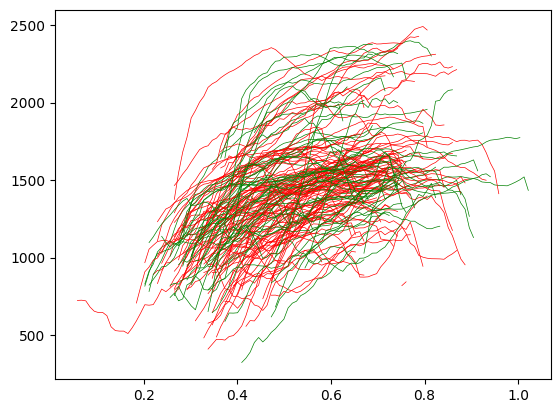

In [218]:
import numpy as np
import pandas as pd
import math
from scipy import signal

ids = []
offsets = []
peak_norms = []
slope1 = []
slope2 = []
dists = []
dist_to_emb = []
init_size1 = []
init_size2 = []
avg_degree = []
max_size = []
q1_size = []
q2_size = []
q1_solidity = []
q2_solidity = []

appear_pn1 = []
appear_pn2 = []
dt_appear = []
fade_pn1 = []
fade_pn2 = []

target_list = []


for id_ in merged_df['embryo_id'].to_list():
    ids.append(id_)

    target_list.append(merged_df[merged_df['embryo_id']==id_]['y'].values[0])

# for id_ in merged_df['embryo_id'].unique():
    # First PN: fill NaNs, compute time, extract active segment
    # group1 = group1.copy()
    group1 = full_pn1_df[full_pn1_df['embryo_id'] == id_].copy().reset_index(drop=True)
    group1['area'] = group1['area'].fillna(1)
    group1['time'] = group1['dt'].cumsum()
    start1, len1 = find_signal(group1['area'].values != 1)
    first_pn = group1.iloc[start1 : start1 + len1].reset_index(drop=True)

    # Second PN: same steps
    group2 = full_pn2_df[full_pn2_df['embryo_id'] == id_].copy().reset_index(drop=True)
    group2['area'] = group2['area'].fillna(1)
    group2['time'] = group2['dt'].cumsum()
    start2, len2 = find_signal(group2['area'].values != 1)
    second_pn = group2.iloc[start2 : start2 + len2].reset_index(drop=True)

    whole_emb_slice = whole_emb_all_df.loc[whole_emb_all_df['embryo_id']==id_].iloc[start1 : start1 + len1]

    appear_pn1.append(first_pn.iloc[0]['time'])
    appear_pn2.append(second_pn.iloc[0]['time'])

    dt_appear.append(second_pn.iloc[0]['time']-first_pn.iloc[0]['time'])

    fade_pn1.append(first_pn.iloc[-1]['time'])
    fade_pn2.append(second_pn.iloc[-1]['time'])

    init_size1.append(first_pn['area'].iloc[:5].mean()/second_pn['area'].iloc[:5].mean())

    dx = first_pn['x'].values  - group2['x'].iloc[start1 : start1 + len1].values
    dy = first_pn['y'].values  - group2['y'].iloc[start1 : start1 + len1].values
    angle_rad = np.atan2(dy, dx)       # result in radians, ∈ (−π,π]
    angle_deg = np.degrees(angle_rad[~np.isnan(angle_rad)])


    max_size.append(first_pn['area'].max())
    q1_size.append(first_pn['area'].quantile(0.1))
    q2_size.append(first_pn['area'].quantile(0.9))
    avg_degree.append(np.quantile(angle_deg,0.1))

    eccentricity_to_embryo = np.sqrt(
        (first_pn['x'].values - whole_emb_slice['x'].values)**2 +
        (first_pn['y'].values - whole_emb_slice['y'].values)**2
    )
    
    dist_to_emb.append(eccentricity_to_embryo[~np.isnan(eccentricity_to_embryo)].mean())
    dist = np.sqrt(
        (group1['x'].values - group2['x'].values)**2 +
        (group1['y'].values - group2['y'].values)**2
    )
  
    dists.append(dist[~np.isnan(dist)].mean())

    # Offset difference
    offset_diff = (start2 + len2) - (start1 + len1)
    if offset_diff != 0:
        # ids.append(id_)
        offsets.append(offset_diff)

    # Perimeter cross-correlation
    sig1 = first_pn['area']
    sig2 = second_pn['area']
    corr = signal.correlate(sig1, sig2)
    peak = corr.max()
    norm = np.linalg.norm(sig1) * np.linalg.norm(sig2)
    peak_norm = peak / norm if norm != 0 else 0
    peak_norms.append(peak_norm)

    # Area ratio (onl
    
    import statsmodels.api as sm
    mod = sm.OLS( first_pn['area'].values, first_pn['time'].values)
    res = mod.fit()
    
    slope1.append(res.params[0])


    mod = sm.OLS(second_pn['area'].values,second_pn['time'].values, )
    res = mod.fit()

    slope2.append(res.params[0])

    smmoothen_pn1 = first_pn[['time','area']].rolling(12).mean()
    
    embryo_lbl = merged_df.loc[merged_df['embryo_id']==id_]['y'].values[0]

    plt.plot( smmoothen_pn1['time'].values,smmoothen_pn1['area'].values,color='red' if embryo_lbl==0 else 'green', lw=-.5)

In [249]:
pn_extracted_columns = list(final_features_df.dropna(axis=1).columns)
merged_final_df = pd.merge(final_features_df, merged_df, on='embryo_id', how='inner').drop_duplicates('embryo_id')

In [543]:
merged_df['y'] = merged_df['Class_Grade']> 0

In [544]:
merged_df['y']

0      False
1      False
2      False
3      False
4      False
       ...  
158     True
159     True
160     True
161    False
162    False
Name: y, Length: 163, dtype: bool

In [566]:
import numpy as np
import pandas as pd
import math
from scipy import signal
import statsmodels.api as sm

# Prepare list of feature dicts
feature_rows = []

for id_ in merged_df['embryo_id'].to_list():
    try:
        # Load label
        label = merged_df.loc[merged_df['embryo_id'] == id_, 'y'].values[0]

        # Load and preprocess both PNs
        group1 = full_pn1_df[full_pn1_df['embryo_id'] == id_].copy().reset_index(drop=True)
        group2 = full_pn2_df[full_pn2_df['embryo_id'] == id_].copy().reset_index(drop=True)
        group1['area'] = group1['area'].fillna(1)
        group2['area'] = group2['area'].fillna(1)
        group1['time'] = group1['dt'].cumsum()
        group2['time'] = group2['dt'].cumsum()

        # Extract active segments
        start1, len1 = find_signal(group1['area'].values != 1)
        start2, len2 = find_signal(group2['area'].values != 1)
        pn_a = group1.iloc[start1 : start1 + len1].reset_index(drop=True)
        pn_b = group2.iloc[start2 : start2 + len2].reset_index(drop=True)

        # Ensure consistent PN labeling by appearance time
        # if pn_a.iloc[:5]['area'].mean() > pn_b.iloc[:5]['area'].mean():
        #     pn_a, pn_b = pn_b, pn_a

        # Load embryo center data and trim to match PN A length
        whole_emb_slice = whole_emb_all_df.loc[whole_emb_all_df['embryo_id'] == id_].reset_index(drop=True)
        slice_len = min(len(pn_a), len(whole_emb_slice))
        pn_a_trimmed = pn_a.iloc[:slice_len]
        whole_emb_trimmed = whole_emb_slice.iloc[:slice_len]

        # Compute features for this embryo
        dt_appear = abs(pn_b.iloc[0]['time'] - pn_a.iloc[0]['time'])
        duration_diff = abs((pn_a.iloc[-1]['time'] - pn_a.iloc[0]['time']) - (pn_b.iloc[-1]['time'] - pn_b.iloc[0]['time']))
        init_size_ratio = pn_a['area'].iloc[:5].mean() / pn_b['area'].iloc[:5].mean()

        eccentricity_to_embryo = np.sqrt((pn_a_trimmed['x'].values - whole_emb_trimmed['x'].values)**2 + 
                                         (pn_a_trimmed['y'].values - whole_emb_trimmed['y'].values)**2)
        dist_to_emb_val = np.nanmean(eccentricity_to_embryo)

        dist_val = np.sqrt((group1['x'].values - group2['x'].values)**2 + (group1['y'].values - group2['y'].values)**2)
        dist_between_pns = np.nanmean(dist_val)

        dx = pn_a['x'].values - pn_b['x'].reindex(pn_a.index, method='nearest').values
        dy = pn_a['y'].values - pn_b['y'].reindex(pn_a.index, method='nearest').values
        angle_deg = np.degrees(np.arctan2(dy, dx)[~np.isnan(np.arctan2(dy, dx))])
        avg_degree_val = np.quantile(angle_deg, 0.1)

        max_size_val = max(pn_a['area'].max(), pn_b['area'].max())
        q1_size_val = np.mean([pn_a['area'].quantile(0.1), pn_b['area'].quantile(0.1)])
        q2_size_val = np.mean([pn_a['area'].quantile(0.9), pn_b['area'].quantile(0.9)])

        corr = signal.correlate(pn_a['area'], pn_b['area'])
        peak = corr.max()
        norm = np.linalg.norm(pn_a['area']) * np.linalg.norm(pn_b['area'])
        peak_norm_val = peak / norm if norm != 0 else 0

        common_len = min(len(pn_a), len(pn_b))
        area_diff_val = np.linalg.norm(pn_a['area'][:common_len].values - pn_b['area'][:common_len].values)

        slope1_val = sm.OLS(pn_a['area'].values, pn_a['time'].values).fit().params[0]
        slope2_val = sm.OLS(pn_b['area'].values, pn_b['time'].values).fit().params[0]
        slope_diff_val = abs(slope1_val - slope2_val)
        slope_mean_val = (slope1_val + slope2_val) / 2

        feature_rows.append({
            'embryo_id': id_,
            'label': label,
            'dt_appear': dt_appear,
            'duration_diff': duration_diff,
            'init_size_ratio': init_size_ratio,
            'dist_to_emb': dist_to_emb_val,
            'dist_between_pns': dist_between_pns,
            'avg_degree': avg_degree_val,
            'max_size': max_size_val,
            'q1_size': q1_size_val,
            'q2_size': q2_size_val,
            'peak_norm': peak_norm_val,
            'area_diff': area_diff_val,
            'slope_diff': slope_diff_val,
            'slope_mean': slope_mean_val
        })

    except Exception as e:
        print(f"Skipping {id_} due to error: {e}")
        continue

# Create DataFrame from feature rows
features_df = pd.DataFrame(feature_rows)

# Build feature matrix X and label vector y
X = features_df[['slope_mean', 'slope_diff', 'dist_between_pns', 'dist_to_emb',
                 'init_size_ratio', 'max_size', 'q1_size', 'q2_size']].values

y = features_df['label'].values

# Optional: inspect for mismatched rows
print(f"Total embryos processed: {len(feature_rows)}")


Total embryos processed: 163


In [578]:
import numpy as np
import pandas as pd
import math
from scipy import signal
import statsmodels.api as sm

# Prepare list of feature dicts for each pronucleus
feature_rows = []

# First, create mapping for embryo IDs to numeric codes
embryo_ids = merged_df['embryo_id'].unique()
embryo_code_map = {embryo_id: idx for idx, embryo_id in enumerate(embryo_ids)}

for id_ in embryo_ids:
    try:
        # Numeric code for this embryo
        embryo_code = embryo_code_map[id_]
        
        # Load embryo label
        label = merged_df.loc[merged_df['embryo_id'] == id_, 'y'].values[0]

        # Load and preprocess PN1 and PN2 data
        group1 = full_pn1_df[full_pn1_df['embryo_id'] == id_].copy().reset_index(drop=True)
        group2 = full_pn2_df[full_pn2_df['embryo_id'] == id_].copy().reset_index(drop=True)
        group1['area'] = group1['area'].fillna(1)
        group2['area'] = group2['area'].fillna(1)
        group1['time'] = group1['dt'].cumsum()
        group2['time'] = group2['dt'].cumsum()

        # Extract active segment for each PN
        start1, len1 = find_signal(group1['area'].values != 1)
        start2, len2 = find_signal(group2['area'].values != 1)
        pn1 = group1.iloc[start1 : start1 + len1].reset_index(drop=True)
        pn2 = group2.iloc[start2 : start2 + len2].reset_index(drop=True)

        # Ensure consistent PN labeling by appearance time
        if pn1.iloc[0]['time'] > pn2.iloc[0]['time']:
            pn1, pn2 = pn2, pn1
            start1, len1, start2, len2 = start2, len2, start1, len1

        # Load embryo center data
        whole_emb_slice = whole_emb_all_df.loc[whole_emb_all_df['embryo_id'] == id_].reset_index(drop=True)

        # Helper to extract per-PN features, with pn_label = 0 or 1
        def extract_per_pn_features(pn_df, whole_emb, length, pn_label):
            slice_len = min(length, len(whole_emb))
            pn_trim = pn_df.iloc[:slice_len]
            emb_trim = whole_emb.iloc[:slice_len]

            appear_time = pn_trim.iloc[0]['time']
            fade_time = pn_trim.iloc[-1]['time']
            duration = fade_time - appear_time
            init_size = pn_trim['area'].iloc[:5].mean() if len(pn_trim) >= 5 else pn_trim['area'].iloc[0]
            max_size = pn_trim['area'].max()
            q1_size = pn_trim['area'].quantile(0.1)
            q2_size = pn_trim['area'].quantile(0.9)

            # Distance to embryo center (mean)
            dist_to_emb = np.nanmean(
                np.sqrt((pn_trim['x'].values - emb_trim['x'].values)**2 + (pn_trim['y'].values - emb_trim['y'].values)**2)
            )

            # Slope via OLS
            slope_val = sm.OLS(pn_trim['area'].values, pn_trim['time'].values).fit().params[0]

            # Compute a unique pn_id encoding embryo and label (0 or 1)
            pn_id = embryo_code * 2 + pn_label  # since two pronuclei per embryo

            feature_rows.append({
                'pn_id': pn_id,
                'embryo_code': embryo_code,
                'embryo_id': id_,
                'pn_label': pn_label,
                'appear_time': appear_time,
                'fade_time': fade_time,
                'duration': duration,
                'init_size': init_size,
                'max_size': max_size,
                'q1_size': q1_size,
                'q2_size': q2_size,
                'dist_to_emb': dist_to_emb,
                'slope': slope_val,
                'label': label
            })

        # Extract features for each pronucleus: pn_label 0 for first, 1 for second
        extract_per_pn_features(pn1, whole_emb_slice, len1, pn_label=0)
        extract_per_pn_features(pn2, whole_emb_slice, len2, pn_label=1)

    except Exception as e:
        print(f"Skipping PN extraction for embryo {id_} due to error: {e}")
        continue

# Create DataFrame from feature rows
features_df = pd.DataFrame(feature_rows)

# Build feature matrix X and label vector y
X = features_df[['appear_time', 'fade_time', 'duration', 'init_size', 'max_size',
                 'q1_size', 'q2_size', 'dist_to_emb', 'slope']].values

y = features_df['label'].values

# Enumerated PN and Embryo codes available in columns 'pn_id' and 'embryo_code' for splitting
print(f"Total pronuclei processed: {len(features_df)}")


Total pronuclei processed: 326


In [592]:
features_df

,pn_id,embryo_code,embryo_id,pn_label,appear_time,fade_time,duration,init_size,max_size,q1_size,q2_size,dist_to_emb,slope,label
0,0,0,D2017.06.02_S1566_I149_2,0,0.333,0.756,0.423,1180.8,2010.0,1324.8,1922.7,23.035505,2955.554714,False
1,1,0,D2017.06.02_S1566_I149_2,1,0.333,0.756,0.423,1394.6,2265.0,1556.5,2133.2,34.457087,3359.394905,False
2,2,1,D2017.11.22_S01667_I0149_D_2,0,0.243,0.936,0.693,483.6,1635.0,1022.4,1533.3,17.823276,2102.184308,False
3,3,1,D2017.11.22_S01667_I0149_D_2,1,0.243,0.936,0.693,504.2,1718.0,958.9,1672.6,22.277555,2246.614885,False
4,4,2,D2017.11.22_S01667_I0149_D_6,0,0.333,0.891,0.558,839.6,2176.0,1123.6,1687.6,42.056189,2336.109830,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321,321,160,D2018.01.27_S01708_I0149_D_5,1,0.234,0.765,0.531,878.2,1731.0,1269.8,1628.8,22.024815,2745.671647,True
322,322,161,D2018.06.20_S01830_I0149_D_4,0,0.279,0.972,0.693,766.6,1811.0,1177.9,1707.6,14.736341,2123.370195,False
323,323,161,D2018.06.20_S01830_I0149_D_4,1,0.279,0.972,0.693,794.4,1868.0,1253.8,1797.1,26.007655,2267.278513,False
324,324,162,D2018.09.12_S01858_I0149_D_5,0,0.279,0.729,0.450,483.8,1867.0,699.0,1805.0,20.161104,2723.016309,False


In [ ]:
X = np.stack([slope1, slope2, dists, dist_to_emb,  init_size1, max_size, q1_size, q2_size]).transpose()


ValueError: all input arrays must have the same shape

In [ ]:
X = np.stack([slope1, slope2, dists, dist_to_emb,  init_size1, max_size, q1_size, q2_size]).transpose()

# X =  np.concatenate([X,merged_final_df[pn_extracted_columns[1:]+time_features].fillna(0).values],axis=1)

In [375]:
from sklearn.linear_model import LinearRegression


r2 = LinearRegression().fit(X, target_list).score(X, target_list)
print(f"Combined R²: {r2:.3f}")

Combined R²: 0.508


In [376]:
from scipy.stats import pointbiserialr
pointbiserialr(merged_df['y'],dt_appear )

KeyError: 'y'

In [377]:
from scipy.stats import pointbiserialr
pointbiserialr(merged_df['y'], slope2 )

KeyError: 'y'

In [378]:
from scipy.stats import pointbiserialr, norm
import numpy as np

# 1. compute r and p
r, p = pointbiserialr(merged_df['y'], slope1)
n = len(merged_df)

# 2. Fisher z-transform and standard error
z = np.arctanh(r)
se = 1/np.sqrt(n - 3)

# 3. critical z for 95% CI
z_crit = norm.ppf(1 - 0.05/2)

# 4. CI in z-space, then back-transform to r
lo_z, hi_z = z - z_crit*se, z + z_crit*se
lo_r, hi_r = np.tanh([lo_z, hi_z])

print(f"r = {r:.3f}, p = {p:.3g}")
print(f"95% CI for r = ({lo_r:.3f}, {hi_r:.3f})")


KeyError: 'y'

In [379]:
merged_df.loc[merged_df['embryo_id'].isin(ids)]['y']

KeyError: 'y'

In [380]:
merged_df.loc[merged_df['embryo_id'].isin(ids)]['y'].sum()

KeyError: 'y'

In [381]:
important_['time'].cumsum()

NameError: name 'important_' is not defined

In [382]:
means = full_pn1_df.groupby('embryo_id').apply(lambda x: x[simple_features].mean())

means1 = full_pn2_df.groupby('embryo_id').apply(lambda x: x[simple_features].mean())

q1 = full_pn2_df.groupby('embryo_id').apply(lambda x: x[simple_features].quantile(0.1))

q2 = full_pn2_df.groupby('embryo_id').apply(lambda x: x[simple_features].quantile(0.9))



/tmp/ipykernel_800892/2096497004.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  means = full_pn1_df.groupby('embryo_id').apply(lambda x: x[simple_features].mean())
/tmp/ipykernel_800892/2096497004.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  means1 = full_pn2_df.groupby('embryo_id').apply(lambda x: x[simple_features].mean())
/tmp/ipykernel_800892/2096497004.py:5: DeprecationWarning: DataFrameGro

In [383]:
simple_features =['area']

In [500]:
from tsfresh.feature_extraction import ComprehensiveFCParameters, MinimalFCParameters
# ...
from tsfresh.feature_extraction import extract_features
settings = MinimalFCParameters()
# Set here the options of the settings object as shown in the paragraphs below


extracted_features = extract_features(full_pn1_df[simple_features+['time','embryo_id']].fillna(0), column_id='embryo_id', column_sort='time', default_fc_parameters=settings)


extracted_features2 = extract_features(full_pn2_df[simple_features+['time','embryo_id']].fillna(0), column_id='embryo_id', column_sort='time', default_fc_parameters=settings)

Feature Extraction: 100%|██████████| 55/55 [00:00<00:00, 2834.79it/s]


In [501]:

both_pn_extracted = pd.merge(extracted_features, extracted_features2, left_index=True, right_index=True)
non_dead_features = list(both_pn_extracted.var().loc[(both_pn_extracted.var()>1)].index)

In [502]:
extracted_features = extracted_features.reset_index(names='embryo_id')

extracted_features2 = extracted_features2.reset_index(names='embryo_id')

In [503]:
extracted_features

,embryo_id,area__sum_values,area__median,area__mean,area__length,area__standard_deviation,area__variance,area__root_mean_square,area__maximum,area__absolute_maximum,area__minimum
0,D2017.01.25_S1483_I149_1,86755.0,0.0,433.775,200.0,666.084608,443668.704375,794.877006,1853.0,1853.0,0.0
1,D2017.01.25_S1483_I149_10,96869.0,0.0,484.345,200.0,637.386128,406261.075975,800.531795,1845.0,1845.0,0.0
2,D2017.01.25_S1483_I149_12,91455.0,0.0,457.275,200.0,608.320877,370054.289375,761.022151,1826.0,1826.0,0.0
3,D2017.01.25_S1483_I149_3,102936.0,193.0,514.680,200.0,597.338654,356813.467600,788.485238,1673.0,1673.0,0.0
4,D2017.01.25_S1483_I149_4,87111.0,0.0,435.555,200.0,649.413841,421738.336975,781.950443,1797.0,1797.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
158,D2019.04.16_S01982_I0149_D_5,84499.0,0.0,422.495,200.0,611.328365,373722.369975,743.118022,1646.0,1646.0,0.0
159,D2019.04.16_S01982_I0149_D_7,98173.0,0.0,490.865,200.0,663.819431,440656.236775,825.593535,1825.0,1825.0,0.0
160,D2019.04.20_S01983_I0149_D_5,66542.0,0.0,332.710,200.0,556.874758,310109.495900,648.695183,1729.0,1729.0,0.0
161,D2019.04.22_S01986_I0149_D_10,74289.0,0.0,371.445,200.0,546.585581,298755.796975,660.853376,1418.0,1418.0,0.0


In [504]:


both_pn_extracted = both_pn_extracted.reset_index(names='embryo_id')

In [505]:
merged_df['Class_Grade']

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
158    2.0
159    2.0
160    2.0
161    NaN
162    NaN
Name: Class_Grade, Length: 163, dtype: float64

In [506]:
with_targ = pd.merge(merged_df[['Class_Grade','embryo_id']], both_pn_extracted[non_dead_features+['embryo_id']], on='embryo_id', how='right')

In [507]:
with_targ.drop('embryo_id',axis=1).corr().index[(with_targ.drop('embryo_id',axis=1).corr()['y'].abs().sort_values()>0.15).sum()]

KeyError: 'y'

In [577]:
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, StratifiedGroupKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, roc_auc_score, f1_score,confusion_matrix

In [ ]:
# X =features_df.drop(['label','embryo_id'],axis=1)# with_targ.drop_duplicates(subset=['embryo_id']).drop(['y','embryo_id'],axis=1).values
# y =target_list# merged_df.drop_duplicates(subset=['embryo_id'])['y']>1

# X = with_targ.drop(['embryo_id','Class_Grade'],axis=1).values

In [510]:
with_targ.drop(['embryo_id','Class_Grade'],axis=1)

,area__sum_values_x,area__median_x,area__mean_x,area__standard_deviation_x,area__variance_x,area__root_mean_square_x,area__maximum_x,area__absolute_maximum_x,area__sum_values_y,area__median_y,area__mean_y,area__standard_deviation_y,area__variance_y,area__root_mean_square_y,area__maximum_y,area__absolute_maximum_y
0,86755.0,0.0,433.775,666.084608,443668.704375,794.877006,1853.0,1853.0,74907.0,0.0,374.535,574.255386,329769.248775,685.598800,1682.0,1682.0
1,96869.0,0.0,484.345,637.386128,406261.075975,800.531795,1845.0,1845.0,92598.0,0.0,462.990,618.561476,382618.299900,772.643540,1867.0,1867.0
2,91455.0,0.0,457.275,608.320877,370054.289375,761.022151,1826.0,1826.0,99452.0,0.0,497.260,636.582133,405236.812400,807.777395,1636.0,1636.0
3,102936.0,193.0,514.680,597.338654,356813.467600,788.485238,1673.0,1673.0,91428.0,0.0,457.140,588.275582,346068.160400,745.013517,1670.0,1670.0
4,87111.0,0.0,435.555,649.413841,421738.336975,781.950443,1797.0,1797.0,79953.0,0.0,399.765,620.552536,385085.449775,738.171731,1656.0,1656.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,84499.0,0.0,422.495,611.328365,373722.369975,743.118022,1646.0,1646.0,76918.0,0.0,384.590,599.325906,359191.541900,712.110251,1743.0,1743.0
159,98173.0,0.0,490.865,663.819431,440656.236775,825.593535,1825.0,1825.0,101850.0,0.0,509.250,676.133202,457156.107500,846.458310,1897.0,1897.0
160,66542.0,0.0,332.710,556.874758,310109.495900,648.695183,1729.0,1729.0,66837.0,0.0,334.185,548.992587,301392.860775,642.707146,1566.0,1566.0
161,74289.0,0.0,371.445,546.585581,298755.796975,660.853376,1418.0,1418.0,73809.0,0.0,369.045,537.170395,288552.032975,651.725590,1396.0,1396.0


In [511]:
(y-features_df['label']).max()

np.float64(1.0)

In [512]:
pn1_features['time'] = pn1_features['dt'].cumsum()
pn2_features['time'] = pn2_features['dt'].cumsum()

In [513]:
X.shape

(163, 16)

In [514]:
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

In [522]:
X

array([[ 86755.        ,      0.        ,    433.775     , ...,
           685.59880032,   1682.        ,   1682.        ],
       [ 96869.        ,      0.        ,    484.345     , ...,
           772.64354006,   1867.        ,   1867.        ],
       [ 91455.        ,      0.        ,    457.275     , ...,
           807.77739508,   1636.        ,   1636.        ],
       ...,
       [ 66542.        ,      0.        ,    332.71      , ...,
           642.7071456 ,   1566.        ,   1566.        ],
       [ 74289.        ,      0.        ,    371.445     , ...,
           651.72559026,   1396.        ,   1396.        ],
       [120386.        ,    221.        ,    601.93      , ...,
          1015.75357002,   2071.        ,   2071.        ]],
      shape=(163, 16))

In [583]:
X


array([[3.33000000e-01, 7.56000000e-01, 4.23000000e-01, ...,
        1.92270000e+03, 2.30355050e+01, 2.95555471e+03],
       [3.33000000e-01, 7.56000000e-01, 4.23000000e-01, ...,
        2.13320000e+03, 3.44570872e+01, 3.35939491e+03],
       [2.43000000e-01, 9.36000000e-01, 6.93000000e-01, ...,
        1.53330000e+03, 1.78232763e+01, 2.10218431e+03],
       ...,
       [2.79000000e-01, 9.72000000e-01, 6.93000000e-01, ...,
        1.79710000e+03, 2.60076555e+01, 2.26727851e+03],
       [2.79000000e-01, 7.29000000e-01, 4.50000000e-01, ...,
        1.80500000e+03, 2.01611041e+01, 2.72301631e+03],
       [2.88000000e-01, 7.20000000e-01, 4.32000000e-01, ...,
        1.67780000e+03, 3.04626161e+01, 2.72398816e+03]], shape=(326, 9))

In [ ]:
aucs = []
for _ in range(100):
    folds = StratifiedGroupKFold(10,random_state=np.random.randint(1,10000), shuffle=True)
    for train_idx, test_idx in folds.split(X,y):


        X_train, X_test, y_train, y_test = X[train_idx], X[test_idx], y.iloc[train_idx], y.iloc[test_idx]


        clf = LGBMClassifier(verbose=-1)

        clf.fit(X_train, y_train)
   
        aucs.append(roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]))
       

/home/tsakalis/ntua/phd/pronuclei_detector/pronuclei_detector/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/tsakalis/ntua/phd/pronuclei_detector/pronuclei_detector/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/tsakalis/ntua/phd/pronuclei_detector/pronuclei_detector/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/tsakalis/ntua/phd/pronuclei_detector/pronuclei_detector/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/tsakalis/ntua/phd/pronuclei_de

In [591]:
X[:,4]

array([2010., 2265., 1635., 1718., 2176., 1961., 1822., 1917., 1526.,
       1454., 1592., 1736., 1824., 1679., 1509., 1452., 1684., 1588.,
       1779., 1595., 1859., 1374., 1783., 1502., 1868., 1635., 1718.,
       1681., 1406., 1615., 1885., 1976., 1801., 1724., 1623., 1684.,
       1454., 1478., 1675., 1502., 1429.,  983., 1929., 1882., 1608.,
       1496., 1421., 1663., 1750., 1779., 1555., 1572., 1933., 1852.,
       1575., 1510., 1622., 1657., 1623., 1602., 1837., 1656., 1965.,
       1712., 1754., 1911., 1791., 1727., 1845., 1724., 1951., 1783.,
       1466., 1821., 1638., 1853., 1696., 1547., 1656., 1880., 1703.,
       1648., 1466., 1618., 1776., 1776., 1790., 1691., 1385., 1496.,
       1658., 1376., 1596., 1507., 1656., 1450., 1618., 1692., 1245.,
       1162., 1637., 1489., 1653., 1328., 1646., 1743., 1897., 1825.,
       1729., 1566., 2069., 1597., 1731., 1838., 1938., 1863., 1520.,
       1252., 1576., 1446., 1816., 1368., 1607., 1633., 1935., 2071.,
       2238., 1555.,

In [593]:
features_df

,pn_id,embryo_code,embryo_id,pn_label,appear_time,fade_time,duration,init_size,max_size,q1_size,q2_size,dist_to_emb,slope,label
0,0,0,D2017.06.02_S1566_I149_2,0,0.333,0.756,0.423,1180.8,2010.0,1324.8,1922.7,23.035505,2955.554714,False
1,1,0,D2017.06.02_S1566_I149_2,1,0.333,0.756,0.423,1394.6,2265.0,1556.5,2133.2,34.457087,3359.394905,False
2,2,1,D2017.11.22_S01667_I0149_D_2,0,0.243,0.936,0.693,483.6,1635.0,1022.4,1533.3,17.823276,2102.184308,False
3,3,1,D2017.11.22_S01667_I0149_D_2,1,0.243,0.936,0.693,504.2,1718.0,958.9,1672.6,22.277555,2246.614885,False
4,4,2,D2017.11.22_S01667_I0149_D_6,0,0.333,0.891,0.558,839.6,2176.0,1123.6,1687.6,42.056189,2336.109830,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321,321,160,D2018.01.27_S01708_I0149_D_5,1,0.234,0.765,0.531,878.2,1731.0,1269.8,1628.8,22.024815,2745.671647,True
322,322,161,D2018.06.20_S01830_I0149_D_4,0,0.279,0.972,0.693,766.6,1811.0,1177.9,1707.6,14.736341,2123.370195,False
323,323,161,D2018.06.20_S01830_I0149_D_4,1,0.279,0.972,0.693,794.4,1868.0,1253.8,1797.1,26.007655,2267.278513,False
324,324,162,D2018.09.12_S01858_I0149_D_5,0,0.279,0.729,0.450,483.8,1867.0,699.0,1805.0,20.161104,2723.016309,False


In [603]:
test_group

8        4
9        4
18       9
19       9
28      14
      ... 
289    144
308    154
309    154
318    159
319    159
Name: embryo_code, Length: 64, dtype: int64

In [602]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier
import pymc as pm
import arviz as az

group = features_df['embryo_code']
# 1. Collect AUCs via 5‐fold stratified CV (repeat N times if desired)
aucs = []
n_repeats = 1 # you can adjust this
for _ in range(n_repeats):
    folds = StratifiedGroupKFold(5, shuffle=True, random_state=np.random.randint(1, 1_000_000))
    for train_idx, test_idx in folds.split(X, y, group):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        test_group = group.iloc[test_idx]
        clf = LGBMClassifier(verbose=-1)
        clf.fit(X_train, y_train)
        probas = clf.predict_proba(X_test)[:, 1]
        aucs.append(roc_auc_score(y_test, probas))

aucs = np.array(aucs)


/home/tsakalis/ntua/phd/pronuclei_detector/pronuclei_detector/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/tsakalis/ntua/phd/pronuclei_detector/pronuclei_detector/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/tsakalis/ntua/phd/pronuclei_detector/pronuclei_detector/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/tsakalis/ntua/phd/pronuclei_detector/pronuclei_detector/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/tsakalis/ntua/phd/pronuclei_de

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


/home/tsakalis/ntua/phd/pronuclei_detector/pronuclei_detector/lib/python3.11/site-packages/rich/live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 8_000 draw iterations (4_000 + 32_000 draws total) took 1 seconds.


        mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
mu     0.534  0.003     0.528      0.540        0.0      0.0   14400.0   
sigma  0.071  0.002     0.066      0.075        0.0      0.0   12302.0   

       ess_tail  r_hat  
mu      13326.0    1.0  
sigma   12754.0    1.0  
P(mu > 0.5) = 1.000


<Axes: title={'center': 'mu'}>

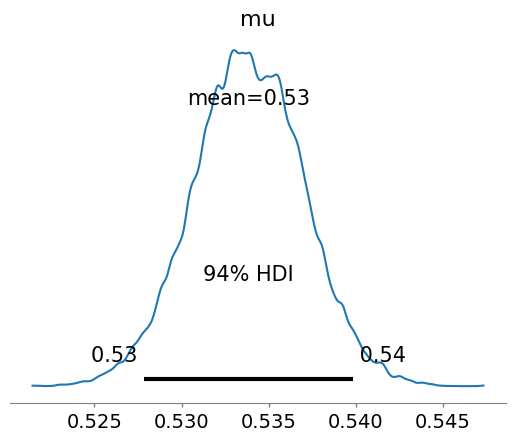

In [600]:

# 2. Build a simple Bayesian model for the AUC distribution
with pm.Model() as auc_model:
    # Prior on the mean AUC (centered at 0.5 with some spread)
    mu = pm.Normal("mu", mu=0.5, sigma=0.1)
    # Prior on the standard deviation of AUCs
    sigma = pm.HalfNormal("sigma", sigma=0.1)
    # Likelihood: observed AUCs ~ Normal(mu, sigma)
    observed = pm.Normal("observed", mu=mu, sigma=sigma, observed=aucs)
    trace = pm.sample(8000, target_accept=0.5)

# 3. Summarize and compute probability that mean AUC > 0.5
posterior_summary = az.summary(trace, var_names=["mu", "sigma"], hdi_prob=0.95)
p_gt_05 = (trace.posterior["mu"] > 0.5).mean().item()

print(posterior_summary)
print(f"P(mu > 0.5) = {p_gt_05:.3f}")
# Optionally, plot the posterior of mu:
az.plot_posterior(trace, var_names=["mu"])








(array([ 1.,  1.,  1.,  0.,  0.,  1.,  0.,  1.,  3.,  1.,  2.,  2.,  1.,
         1.,  1.,  1.,  0.,  5.,  7.,  3.,  3.,  6.,  1.,  3.,  7.,  8.,
         3.,  4.,  8.,  8.,  6.,  5.,  9.,  9.,  6.,  8.,  9., 13.,  9.,
         6., 15., 11.,  7.,  9., 11., 11.,  6.,  9.,  9.,  8., 14.,  5.,
        16., 12., 10., 10., 10.,  9., 14.,  8.,  9.,  8.,  2.,  9.,  5.,
        10., 11.,  9.,  8., 10.,  6.,  4.,  5.,  4.,  3.,  6.,  2.,  1.,
         2.,  1.,  3.,  2.,  1.,  3.,  1.,  1.,  0.,  5.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([0.34412955, 0.34806429, 0.35199903, 0.35593377, 0.3598685 ,
        0.36380324, 0.36773798, 0.37167272, 0.37560745, 0.37954219,
        0.38347693, 0.38741167, 0.3913464 , 0.39528114, 0.39921588,
        0.40315062, 0.40708535, 0.41102009, 0.41495483, 0.41888957,
        0.4228243 , 0.42675904, 0.43069378, 0.43462852, 0.43856325,
        0.44249799, 0.44643273, 0.45036747, 0.4543022 , 0.45823694,
        0.46217168, 0.4661

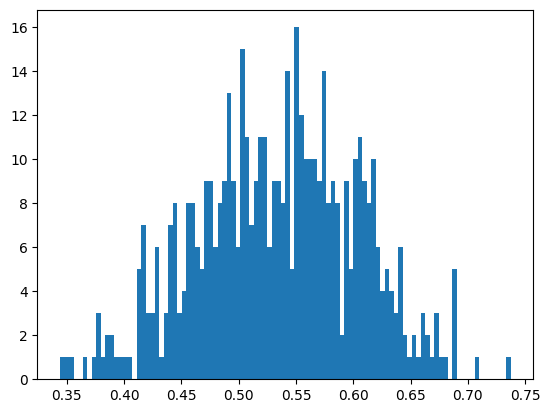

In [599]:
plt.hist(aucs,bins=100)

(array([  3.,   1.,  10.,  17.,  55., 101., 163., 285., 420., 540., 739.,
        717., 631., 547., 363., 235., 114.,  37.,  17.,   5.]),
 array([0.18357488, 0.21830918, 0.25304348, 0.28777778, 0.32251208,
        0.35724638, 0.39198068, 0.42671498, 0.46144928, 0.49618357,
        0.53091787, 0.56565217, 0.60038647, 0.63512077, 0.66985507,
        0.70458937, 0.73932367, 0.77405797, 0.80879227, 0.84352657,
        0.87826087]),
 <BarContainer object of 20 artists>)

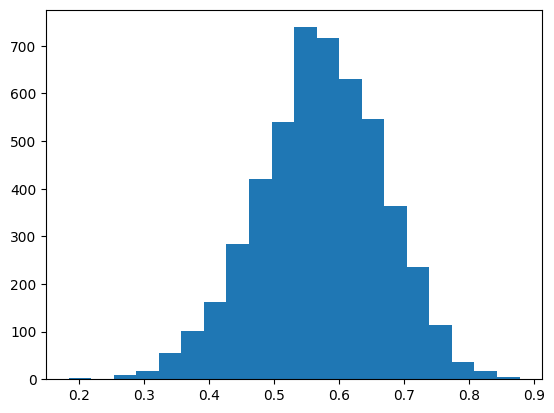

In [245]:
plt.hist(aucs,bins=20)

(array([  2.,  10.,  32.,  83., 214., 366., 420., 272.,  90.,  11.]),
 array([0.39160839, 0.45170681, 0.51180523, 0.57190365, 0.63200207,
        0.69210049, 0.75219891, 0.81229733, 0.87239575, 0.93249417,
        0.99259259]),
 <BarContainer object of 10 artists>)

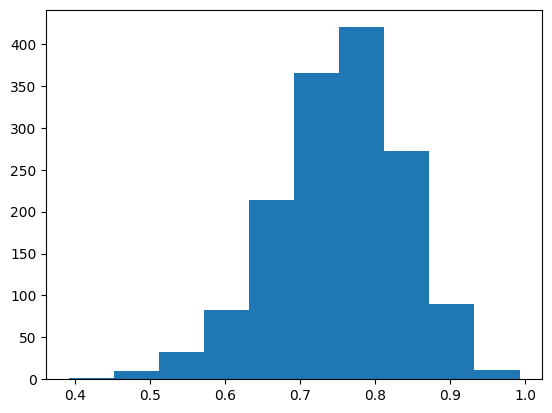

In [154]:
plt.hist(aucs)

In [ ]:
pd.DataFrame(pn1_features)['area'].iloc[:100].argsort()

/tmp/ipykernel_9219/4016114416.py:1: FutureWarning: The behavior of Series.argsort in the presence of NA values is deprecated. In a future version, NA values will be ordered last instead of set to -1.
  pd.DataFrame(pn1_features)['area'].iloc[:100].argsort()


0     -1
1     -1
2     -1
3      1
4      6
      ..
95    -1
96    51
97    -1
98    -1
99    -1
Name: area, Length: 100, dtype: int64

<Axes: >

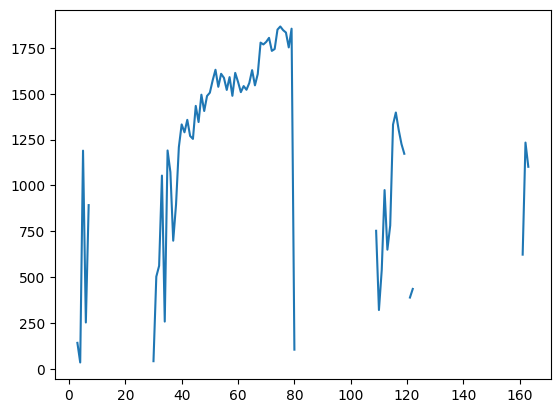

In [ ]:
pd.DataFrame(pn1_features)['area'].plot()
# pd.DataFrame(pn2_features)['x'].plot()

<Axes: >

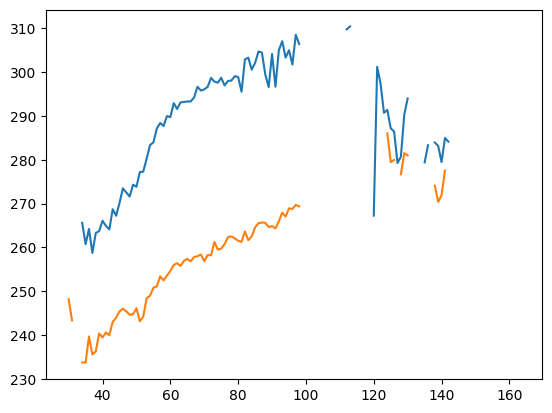

In [ ]:
pd.DataFrame(pn1_features)['x'].plot()
pd.DataFrame(pn2_features)['x'].plot()

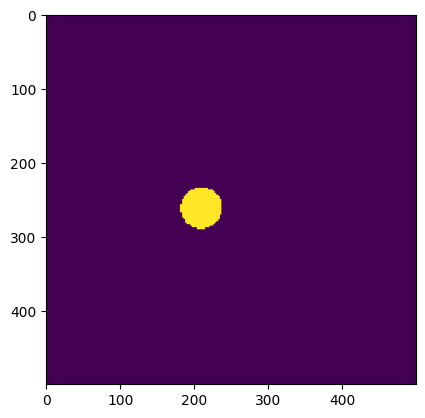

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(masks[83][1])